In [23]:

# IPython magig  tools
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../src/')

import os
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, supplementary_parsing as sp
from aind_vr_foraging_analysis.utils import breathing_signal as bs

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.stats import pearsonr, ttest_rel

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import math 
from matplotlib.ticker import FixedLocator

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from pathlib import Path

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1}

dict_odor = {}
rate = 1
offset = 1
dict_odor['Ethyl Butyrate'] = {'rate':rate, 'offset':offset, 'color': '#d95f02'}
dict_odor['Alpha-pinene'] = {'rate':rate, 'offset':offset, 'color': '#1b9e77'}
dict_odor['Amyl Acetate'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['Methyl Acetate'] = {'rate':rate, 'offset':offset, 'color': color1}
dict_odor['2,3-Butanedione'] = {'rate':rate, 'offset':offset, 'color': color4}
dict_odor['Fenchone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['2-Heptanone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\Conferences\SFN 2024\figures'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
size_col = 4
size_row = 4
sns.set_context("talk")

## **A novel task for studying patch foraging**

### **Velocity traces extend interpretation beyond binary choices**

In [ ]:
def raster_with_velocity(
    active_site: pd.DataFrame,
    stream_data: pd.DataFrame,
    save = None,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
):

    active_patch = -1
    first_entry = True
    patch_onset = pd.DataFrame()
    for index, row in active_site.iterrows():
        if row['label'] == 'InterSite' and active_patch == row['active_patch'] and first_entry:
            new_rows = pd.DataFrame([
            {'active_patch': row['active_patch'], 'patch_onset': row.name}])
            patch_onset = pd.concat([patch_onset, new_rows])
            first_entry = False
            
        if active_patch != row['active_patch']:
            active_patch = row['active_patch']
            first_entry = True
    
    merged_df = pd.merge_asof(active_site, patch_onset, on='active_patch')
    active_site['patch_onset'] = merged_df['patch_onset'].values
    active_site['time_since_entry'] = active_site.index - active_site['patch_onset']
    active_site['exit_epoch'] = active_site['time_since_entry'] + active_site['duration_epoch']
    test_df = active_site.groupby('active_patch').agg({'time_since_entry': 'min', 'patch_onset': 'mean','exit_epoch' : 'max'})
    test_df.reset_index(inplace=True)
    test_df.fillna(15, inplace=True)   
    
    trial_summary = plotting.trial_collection(test_df, stream_data.encoder_data, active_site.mouse.unique()[0], active_site.session.unique()[0], aligned='patch_onset', cropped_to_length=True)

    fig, ax1 = plt.subplots(figsize=(14, 30))
    ax2 = ax1.twinx()
    max_speed = np.quantile(trial_summary['speed'],0.99)
    for index, row in active_site.iterrows():
        if row['label'] == 'InterPatch':
            color = '#b3b3b3'
        elif row['label'] == 'InterSite':
            color = '#808080'
            
        if row['label'] == 'RewardSite':
            if row['visit_number'] == 0:
                ax1.scatter(0, row.active_patch, color=color_dict_label[row.odor_label], marker='s', s=60, edgecolor='black', linewidth=0.0)

            if row["reward_delivered"] == 1 and row["has_choice"] == True:
                color = "steelblue"
            elif row["reward_delivered"] == 0 and row["has_choice"] == True:
                color = "pink"
            else:
                color = 'yellow'
        ax1.barh(int(row['active_patch']), left=row.time_since_entry, height=0.85, width=row.duration_epoch, color=color,  linewidth=0.5)
        
        if row['time_since_entry'] <0:
            current_trial = trial_summary[trial_summary['active_patch'] == row['active_patch']]

            ax2.plot(current_trial['times'], current_trial['speed']+(max_speed*(row['active_patch']))+max_speed/1.8, color='black', linewidth=0.8, alpha=0.8)
            ax2.set_ylim(0, max_speed*(active_site['active_patch'].max()+2))

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Patch number")
    sns.despine()
    ax1.set_ylim(-1, max(active_site.active_patch) + 1)
    if active_site.groupby('active_patch').time_since_entry.min().min() < -200:
        min_range = -200
    else:
        min_range = active_site.groupby('active_patch').time_since_entry.min().min()

    if active_site.groupby('active_patch').time_since_entry.max().max() > 200:
        max_range = 200
    else:
        max_range = active_site.groupby('active_patch').time_since_entry.max().max()
         
    ax1.set_xlim(min_range, max_range)
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()
    return fig

In [ ]:
date = datetime.date.today()
date_string = "6/14/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()
mouse = '716458'

In [ ]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# All this segment is to find the correct session without having the specific path
for file_name in sorted_files:
    
    if session_found == True:
        break
    
    print(file_name)
    # Find specific session sorted by date
    session = file_name[-15:-7]
    if datetime.datetime.strptime(session, "%Y%m%d").date() != date:
        continue
    else:
        print('correct date found')
        session_found = True
        
    # Recover data streams
    session_path = os.path.join(base_path, mouse, file_name)
    session_path = Path(session_path)
    data = parse.load_session_data(session_path)
    
    # Parse data into a dataframe with the main features
    reward_sites, active_site, config = parse.parse_dataframe(data)
    # -- At this step you can save the data into a csv file
    
    # Expand with extra columns
    reward_sites = sp.AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
    
    # Remove segments where the mouse was disengaged
    last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 2].min()
    if pd.isna(last_engaged_patch):
        last_engaged_patch = reward_sites['active_patch'].max()
        
    reward_sites['engaged'] = reward_sites['active_patch'] <= last_engaged_patch  
    reward_sites['mouse'] = mouse
    reward_sites['session'] = session
    reward_sites = reward_sites.loc[reward_sites.engaged ==True]
    
    active_site = sp.AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

    # Load the encoder data separately
    stream_data = parse.ContinuousData(data)
    encoder_data = stream_data.encoder_data
    odor_triggers = stream_data.odor_triggers
        
    active_site['duration_epoch'] = active_site.index.to_series().diff().shift(-1)


In [ ]:
# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

In [ ]:
trial_summary = plotting.trial_collection(reward_sites, 
                                            encoder_data, 
                                            mouse, 
                                            session, 
                                            window=(-1,5)
                                        )

In [ ]:
# active_site.loc[active_site.active_patch <30]
fig = raster_with_velocity(active_site, stream_data, color_dict_label=color_dict_label)
fig.savefig(results_path + f'\{mouse}_raster_velocity.svg', dpi=300)

In [ ]:
def velocity_traces_odor_entry(
    trial_summary,
    window: tuple = (-0.5, 2),
    max_range: int = 60,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
    mean: bool = False,
    save: bool = False,
):
    """Plots the speed traces for each odor label condition"""
    n_odors = trial_summary.odor_label.unique()
    
    fig, ax1 = plt.subplots(
        1, len(n_odors), figsize=(len(n_odors) * 3.5, 4), sharex=True, sharey=True
    )

    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel("Velocity (cm/s)")
        else:
            ax = ax1
            ax.set_ylabel("Velocity (cm/s)")

        ax.set_xlabel("Time after odor onset (s)")
        ax.set_title(f"Patch {odor_label}")
        ax.set_ylim(-13, max_range)
        ax.set_xlim(window)
        ax.hlines(
            5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            0,
            window[1],
            color=color_dict_label[odor_label],
            alpha=0.5,
            linewidth=0,
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            window[0],
            0,
            color="grey",
            alpha=0.3,
            linewidth=0,
        )

        df_results = (
            trial_summary.loc[
                (trial_summary.odor_label == odor_label)
                & (trial_summary.visit_number == 0)
            ]
            .groupby(["odor_sites", "times", "odor_label"])[["speed"]]
            .median()
            .reset_index()
        )

        if df_results.empty:
            continue

        sns.lineplot(
            x="times",
            y="speed",
            data=df_results,
            hue="odor_sites",
            palette=["black"] * df_results["odor_sites"].nunique(),
            legend=False,
            linewidth=0.4,
            alpha=0.4,
            ax=ax,
        )

        if mean:
            overall_median = df_results.groupby("times")["speed"].median().reset_index()
            sns.lineplot(x="times",y="speed",data=overall_median,color="black",errorbar=None,legend=False,linewidth=2,ax=ax,
            )

    sns.despine()
    plt.tight_layout()
    if save != False:
        save.savefig(fig)
    else:
        plt.show()

    plt.close(fig)

In [ ]:
velocity_traces_odor_entry(trial_summary, max_range = trial_summary.speed.max(), 
                           color_dict_label=color_dict_label,
                           mean=True, save=False)

In [ ]:
window = (-1,2)
max_range = 70
fig, ax = plt.subplots(figsize=(size_col, size_row))
sns.lineplot(data=trial_summary.loc[trial_summary.visit_number == 0], x='times', y='speed', hue='odor_label', errorbar='sd', palette=color_dict_label, legend=False)

ax.set_ylabel("Velocity (cm/s)")
ax.set_xlabel("Time after odor onset (s)")
ax.set_ylim(-13, 70)
ax.set_xlim(window)
ax.hlines(
    5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
)
ax.fill_betweenx(
    np.arange(-20, max_range, 0.1),
    window[0],
    0,
    color="grey",
    alpha=0.3,
    linewidth=0,
)
sns.despine()
plt.tight_layout()
fig.savefig(results_path + f'\{mouse}_velocity_traces_first_site.svg', dpi=300)

In [ ]:
window = (-1,5)
max_range = 70
fig, ax = plt.subplots(figsize=(size_col, size_row))
sns.lineplot(data=trial_summary.loc[(trial_summary.has_choice == 1)&(trial_summary.reward_delivered == 1)], x='times', y='speed', hue='odor_label', palette=color_dict_label, legend=False, errorbar='sd')
ax.set_ylabel("Velocity (cm/s)")
ax.set_xlabel("Time after odor onset (s)")
ax.set_ylim(-13, 70)
ax.set_xlim(window)
ax.hlines(
    5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
)
ax.fill_betweenx(
    np.arange(-20, max_range, 0.1),
    window[0],
    0,
    color="grey",
    alpha=0.3,
    linewidth=0,
)
sns.despine()
plt.tight_layout()

In [ ]:
trial_summary['cumulative_type'] = np.where(trial_summary['cumulative_failures'] >= 4, '>= 4 failures', '< 4 failures')

In [ ]:
window = (-1,3.5)
max_range = 70
fig, ax = plt.subplots(figsize=(size_col, size_row))
sns.lineplot(data=trial_summary.loc[(trial_summary.has_choice == 1)&(trial_summary.reward_delivered == 0)], x='times', y='speed', hue='cumulative_type', palette='rocket_r', errorbar='sd')
ax.set_ylabel("Velocity (cm/s)")
ax.set_xlabel("Time after odor onset (s)")
ax.set_ylim(-13, max_range)
ax.set_xlim(window)
ax.hlines(
    5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
)
ax.fill_betweenx(
    np.arange(-20, max_range, 0.1),
    window[0],
    0,
    color="grey",
    alpha=0.3,
    linewidth=0,
)
sns.despine()
plt.xticks(np.arange(-1, 4, 1))
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.tight_layout()

fig.savefig(results_path + f'\{mouse}_velocity_traces_failures.svg', dpi=300)

#### **Distinct sniffing patterns for different choices**

In [ ]:
date = datetime.date.today()
date_string = "07/17/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

mouse = '716455'
# mouse = '754574'

In [ ]:
summary_df = pd.DataFrame()

session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
pdf_filename = f'{mouse}_breathing_summary.pdf'
# All this segment is to find the correct session without having the specific path

for file_name in sorted_files:
    # Recover data streams
    session_path = os.path.join(base_path, mouse, file_name)
    session_path = Path(session_path)
    
    if session_found == True:
        break
    
    # Find specific session sorted by date
    session = file_name[-15:-7]
    if datetime.datetime.strptime(session, "%Y%m%d").date() != date:
        continue
    else:
        print(file_name)
        session_found = True

data = parse.load_session_data(session_path)

if session_found == False:
    print('Session not found')
    
# Parse data into a dataframe with the main features
reward_sites, active_site, config = parse.parse_dataframe(data)
# -- At this step you can save the data into a csv file

# Load the encoder data separately
stream_data = parse.ContinuousData(data)
encoder_data = stream_data.encoder_data
breathing = stream_data.breathing

# Add odor triggers onto reward sites
reward_sites = sp.assign_odor_triggers(reward_sites, stream_data.odor_triggers)

# Expand with extra columns
expanded_dataset = sp.AddExtraColumns(reward_sites, active_site, run_on_init=True)
reward_sites = expanded_dataset.reward_sites
active_site = expanded_dataset.total_epochs

reward_sites['total_sites'] = np.arange(len(reward_sites))
reward_sites['odor_to_stop'] = reward_sites['stop_cue'] - reward_sites['odor_onset']
reward_sites['odor_to_water'] = reward_sites['water_onset'] - reward_sites['odor_onset']

# Standard filter for sniff data
breathing = bs.filtering_standard(breathing, set_moving_average=False)

fig = plt.figure(figsize=(8, 4))
peaks, troughs = bs.findpeaks_and_plot(breathing.filtered_data, breathing.index, fig, color='black', 
                                    distance=10, prominence=1,
                                    range_plot=[breathing.index[6000], breathing.index[5000]])
plt.show()

troughs.index = troughs.locations_troughs
peaks.index = peaks.locations_peaks

# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

print('Extracting trials')
window = [-1,10]
align = 'odor_onset'
selected_columns = ['has_choice', 'total_sites', 'odor_label', 'visit_number', 'odor_duration', 
                    'odor_onset', 'odor_offset', 'stop_cue', 'reward_delivered', 'water_onset','odor_to_water', 'odor_to_stop']

# trial_summary = plotting.trial_collection(reward_sites, breathing, mouse, session, aligned='odor_onset', window=window, taken_col='data')
raw_signal = plotting.trial_collection(reward_sites[selected_columns], 
                                                breathing, mouse, session, window=window, aligned=align, taken_col='filtered_data')


frequency_troughs = plotting.trial_collection(reward_sites[selected_columns], 
                                                troughs, mouse, session, 
                                                window=window, 
                                                aligned=align, 
                                                taken_col='instantaneous_frequency', 
                                                continuous=False)

raster = plotting.trial_collection(reward_sites[selected_columns], 
                                                troughs, 
                                                mouse, 
                                                session, 
                                                window=window, 
                                                aligned=align, 
                                                taken_col='locations_troughs', 
                                                continuous=False)

velocity = plotting.trial_collection(reward_sites[selected_columns], 
                                                encoder_data, 
                                                mouse, 
                                                session, 
                                                window=window, 
                                                aligned=align, 
                                                taken_col='filtered_velocity')
print('Summary sniffs')

# bs.plot_sniff_raster_odor_conditioned(raster,
#                                 velocity)

In [ ]:
raster = raster.loc[raster.odor_label != 'Amyl Acetate']
velocity = velocity.loc[velocity.odor_label != 'Amyl Acetate']

In [ ]:
fig = bs.plot_sniff_raster_conditioned_simple(raster, 
                                  velocity,
                                  condition = 'has_choice',
                                  condition_values = [1, 0],
                                  colors = ['crimson', 'steelblue'],
                                  all_axes = None, window=[-1,4])       
fig.savefig(os.path.join(results_path, f'{mouse}_{session}_sniff_raster_conditioned_has_choice.svg'), dpi=300, bbox_inches='tight')                          

In [ ]:
fig = bs.plot_sniff_raster_conditioned_simple(raster.loc[raster.has_choice == 1], 
                                  velocity.loc[velocity.has_choice == 1],
                                  condition = 'reward_delivered',
                                  condition_values = [1, 0],
                                  colors = ['crimson', 'steelblue'],
                                  all_axes = None, window=[-1,4])       
fig.savefig(os.path.join(results_path, f'{mouse}_{session}_sniff_raster_conditioned_reward_delivered.svg'), dpi=300, bbox_inches='tight')                          

In [ ]:
velocity['stop_cue_aligned'] = velocity['stop_cue'] - velocity['time_reference']
raster['stop_cue_aligned'] = raster['stop_cue'] - raster['time_reference']
frequency_troughs['stop_cue_aligned'] = frequency_troughs['stop_cue'] - frequency_troughs['time_reference']

In [ ]:
def plot_sniff(total_site):
        
    # Plot the signal
    fig, axes = plt.subplots(3,1, figsize= (5,8), sharex=True, gridspec_kw={'height_ratios': [2, 1, 2]})
    
    color = color_dict_label[raw_signal.odor_label.unique()[0]]

    total_sites_df = raw_signal.loc[raw_signal.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['filtered_data']
    max_signal = max(raw_signal.filtered_data.values)
    min_signal = min(raw_signal.filtered_data.values)
    
    # Plot the signal
    ax = axes[0]
    ax.plot(time, signal, color='black',linewidth=1.5)
    # ax.set_title(f'Stop: {total_sites_df.has_choice.unique()[0]} \n Odor: {total_sites_df.odor_label.unique()[0]}  Odor site: {total_sites_df.visit_number.unique()[0]}')
    ax.set_ylabel('Amplitude (a.u.)')
    ax.set_ylim(-2000,2000)

    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df['odor_duration'].unique(), color=color, alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), -1, 0, color='grey', alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_duration'].unique(), total_sites_df['odor_duration'].unique()+1, color='grey', alpha=.5, linewidth=0)
    else:
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), -total_sites_df['odor_duration'].unique(), 0, color=color, alpha=.5, linewidth=0)
    

    ax = axes[1]
    total_sites_df = frequency_troughs.loc[frequency_troughs.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['instantaneous_frequency']
    # axes[0].vlines(time, min_signal, max_signal, color='black', alpha=0.5)
    max_signal = max(frequency_troughs.instantaneous_frequency.values)
    min_signal = min(frequency_troughs.instantaneous_frequency.values)
    # ax.vlines(time, 0, 15, color='black', alpha=0.5)
    ax.set_ylim(0,10)
    ax.plot(time, signal, color='black', linewidth=1.5
            )
    
    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(0,max_signal,0.1), 0, total_sites_df['odor_duration'].unique(), color=color, alpha=.5, linewidth=0)
        ax.set_xlim(-1,total_sites_df['odor_duration'].unique()+1)
        ax.fill_betweenx(np.arange(0,max_signal,0.1), -1, 0, color='grey', alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(0,max_signal,0.1), total_sites_df['odor_duration'].unique(), total_sites_df['odor_duration'].unique()+1, color='grey', alpha=.5, linewidth=0)
    else:
        ax.fill_betweenx(np.arange(0,max_signal,0.1), -total_sites_df['odor_duration'].unique(), 0, color=color, alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(0,max_signal,0.1), -total_sites_df['odor_duration'].unique(), 0, color='grey', alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(0,max_signal,0.1), -total_sites_df['odor_duration'].unique(), 0, color='grey', alpha=.5, linewidth=0)

    ax.set_ylabel('Frequency \n (Hz)')
    
    ax = axes[2]
    total_sites_df = velocity.loc[velocity.total_sites == total_site]
    time = total_sites_df['times']
    signal = total_sites_df['speed']
    max_signal = max(velocity.speed.values)
    min_signal = min(velocity.speed.values)
    
    ax.plot(time, signal, color='black', linewidth=1.5)
    
    if align == 'odor_onset':
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), 0, total_sites_df['odor_duration'].unique(), color=color, alpha=.5, linewidth=0)
        ax.set_xlim(-1,total_sites_df['odor_duration'].unique()+1)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), -1, 0, color='grey', alpha=.5, linewidth=0)
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), total_sites_df['odor_duration'].unique(), total_sites_df['odor_duration'].unique()+1, color='grey', alpha=.5, linewidth=0)
        
    else:
        ax.fill_betweenx(np.arange(min_signal,max_signal,0.1), -total_sites_df['odor_duration'].unique(), 0, color=color, alpha=.5, linewidth=0)

    ax.plot(total_sites_df.stop_cue_aligned.unique(), 10, marker = 's')
    ax.set_ylabel('Velocity (cm/s)')
    ax.set_xlabel('Time from odor onset (s)')
    ax.hlines(0, -1, 10, color='black', linestyle='--')
    ax.set_ylim(-10, 60)
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(results_path, f'{mouse}_{session}_sniff_summary.svg'))

def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='Site:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(plot_sniff, {'total_site': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


##### Controlling for speed

In [ ]:
# Assuming active_site is your DataFrame and it has a 'label' column
# Shift the index to get the next row's index
active_site['next_index'] = active_site.index.to_series().shift(-1)
active_site['epoch_duration'] = active_site['next_index'] - active_site.index
active_site['middle_epoch'] = active_site['epoch_duration'] / 2

velocity_all = pd.DataFrame()
raster_all = pd.DataFrame()

In [ ]:
selected_columns = ['has_choice', 'total_sites', 'active_patch', 'next_index', 'middle_epoch']

velocity = plotting.trial_collection(active_site.loc[active_site['label'] == 'InterPatch'][selected_columns], 
                                                encoder_data, 
                                                mouse, 
                                                session, 
                                                window=[-1,10],  
                                                cropped_to_length='sniff',
                                                taken_col='filtered_velocity')

frequency_troughs = plotting.trial_collection(active_site.loc[active_site['label'] == 'InterPatch'][selected_columns], 
                                                troughs, mouse, session, 
                                                window=[-1,10], 
                                                cropped_to_length='sniff', 
                                                taken_col='instantaneous_frequency', 
                                                continuous=False)

raster = plotting.trial_collection(active_site.loc[active_site['label'] == 'InterPatch'][selected_columns], 
                                                troughs, 
                                                mouse, 
                                                session, 
                                                window=[-1,10], 
                                                cropped_to_length='sniff',
                                                taken_col='locations_troughs', 
                                                continuous=False)

In [ ]:
# Calculate the rolling mean for the previous 30 rows
window=250
velocity['prev_30_mean'] = velocity['speed'].rolling(window=window, min_periods=1).mean()

# Calculate the rolling mean for the next 30 rows by shifting the rolling window
velocity['next_30_mean'] = velocity['speed'].shift(-window).rolling(window=window, min_periods=1).mean()

# Compute the difference between the previous 30 rows mean and the next 30 rows mean
velocity['mean_diff'] = velocity['next_30_mean'] - velocity['prev_30_mean']

velocity['dramatic_change'] = np.where(velocity['mean_diff'] <= -20, 1, 0)
list_patches = velocity.loc[velocity.dramatic_change ==1]['active_patch'].unique()

velocity['change_diff'] = velocity['dramatic_change'].diff()

In [ ]:
sns.lineplot(data=velocity.loc[~velocity.active_patch.isin(list_patches)], x='times', y='speed', color='black', linewidth=1, hue='active_patch', errorbar=None, legend=False)
sns.despine()

In [ ]:
sns.lineplot(data=velocity.loc[velocity.active_patch.isin(list_patches)], x='times', y='speed', color='black', linewidth=1, hue='active_patch', errorbar=None, legend=False)
sns.despine()

In [ ]:
### Epochs for running
velocity_run = velocity.loc[~velocity.active_patch.isin(list_patches)]
velocity_run['aligned_times'] = velocity_run.times - velocity_run.middle_epoch
velocity_run['aligned_times'] = velocity_run['aligned_times'].round(2)
velocity_run['type'] = 'run'

velocity_all = pd.concat([velocity_all, velocity_run])


# Identify the first dramatic change for each active_patch
first_dramatic_changes = velocity_run[np.around(velocity_run['aligned_times'],2) == 0].groupby('active_patch').first().reset_index()

# Function to realign times based on the transition row
def realign_times(df, transition_time):
    df['aligned_times'] = df['times'] - transition_time
    return df

# Apply the realignment for each first dramatic change row within each active_patch in the raster dataset
aligned_raster = pd.DataFrame()
for _, transition_row in first_dramatic_changes.iterrows():
    # Get the active_patch and transition time of the transition row
    active_patch = transition_row['active_patch']
    transition_time = transition_row['times']
    
    # Filter the raster DataFrame for the current active_patch
    temp_df = raster[raster['active_patch'] == active_patch].copy()
    
    # Realign times for the current active_patch based on the transition time
    temp_df = realign_times(temp_df, transition_time)
    
    # Append the aligned DataFrame to the result
    aligned_raster = pd.concat([aligned_raster, temp_df])

# Drop duplicates to avoid multiple alignments of the same rows
aligned_raster = aligned_raster.drop_duplicates()
aligned_raster['type'] = 'run'
raster_all = pd.concat([raster_all, aligned_raster])

In [ ]:
### Epochs for stopping

# Identify the rows where the difference is 1, indicating a transition from 0 to 1 within each active_patch
transition_rows = velocity[velocity['change_diff'] == 1]

# Function to realign times based on the transition row
def realign_times(df, transition_row):
    transition_time = transition_row['times']
    df['aligned_times'] = df['times'] - transition_time
    return df

# Apply the realignment for each transition row within each active_patch
aligned_velocity = pd.DataFrame()
for _, transition_row in transition_rows.iterrows():
    # Get the active_patch of the transition row
    active_patch = transition_row['active_patch']
    
    # Filter the DataFrame for the current active_patch
    temp_df = velocity[velocity['active_patch'] == active_patch].copy()
    
    # Realign times for the current active_patch based on the transition row
    temp_df = realign_times(temp_df, transition_row)
    
    # Append the aligned DataFrame to the result
    aligned_velocity = pd.concat([aligned_velocity, temp_df])

# Drop duplicates to avoid multiple alignments of the same rows
aligned_velocity = aligned_velocity.drop_duplicates()
aligned_velocity['aligned_times'] = aligned_velocity['aligned_times'].round(2)
aligned_velocity['type'] = 'stop'
velocity_all = pd.concat([velocity_all, aligned_velocity])

# Identify the first dramatic change for each active_patch
first_dramatic_changes = velocity[velocity['change_diff'] == 1].groupby('active_patch').first().reset_index()

# Function to realign times based on the transition row
def realign_times(df, transition_time):
    df['aligned_times'] = df['times'] - transition_time
    return df

# Apply the realignment for each first dramatic change row within each active_patch in the raster dataset
aligned_raster = pd.DataFrame()
for _, transition_row in first_dramatic_changes.iterrows():
    # Get the active_patch and transition time of the transition row
    active_patch = transition_row['active_patch']
    transition_time = transition_row['times']
    
    # Filter the raster DataFrame for the current active_patch
    temp_df = raster[raster['active_patch'] == active_patch].copy()
    
    # Realign times for the current active_patch based on the transition time
    temp_df = realign_times(temp_df, transition_time)
    
    # Append the aligned DataFrame to the result
    aligned_raster = pd.concat([aligned_raster, temp_df])

# Drop duplicates to avoid multiple alignments of the same rows
aligned_raster = aligned_raster.drop_duplicates()
aligned_raster['type'] = 'stop'
raster_all = pd.concat([raster_all, aligned_raster])

    

In [ ]:
def plot_sniff_raster_simple(test_df, axes1, axes2, 
                           color, 
                           window: list = [-1, 5], 
                           range_step: float= 0.05, 
                           max_trial: int = 0, 
                           align: str = 'aligned_times'):
    test_df['new_trial'] = pd.factorize(test_df['active_patch'])[0]
    x= test_df[align]    
    y= test_df.new_trial + max_trial
    axes1.plot(x, y, 'o', color=color, markersize=1, marker='.')
    axes1.set_ylabel('Trial')
    
    # time_bins = np.arange(window[0], window[1], range_step)
    # heights, bin_edges, _ = axes2.hist(x, bins=time_bins, color=color, alpha=0.5, histtype='step', 
    #         edgecolor=color, weights=np.ones(len(x)) /  test_df.new_trial.nunique()/range_step)
    
    # Define overlapping bins
    overlap = range_step/2
    time_bins = np.arange(window[0], window[1] + range_step, overlap)

    # Calculate histogram values for each bin
    heights = []
    for i in range(len(time_bins) - 1):
        bin_start = time_bins[i]
        bin_end = time_bins[i] + range_step
        bin_count = ((x >= bin_start) & (x < bin_end)).sum()
        heights.append(bin_count / test_df.new_trial.nunique() / range_step)

    # Plot the histogram with overlapping bins
    axes2.plot(time_bins[:-1], heights, color=color, alpha=0.5, drawstyle='steps-post')

    # Apply rolling average
    heights_series = pd.Series(heights)
    heights_smoothed = heights_series.rolling(window=2, center=True).mean()
    axes2.plot(time_bins[:-1], heights_smoothed, color=color)

    axes2.set_ylabel('Frequency')
    axes2.set_xlim(window[0], window[1])
    

In [ ]:
def plot_sniff_raster_conditioned_simple(raster, 
                                  velocity,
                                  condition = 'has_choice',
                                  condition_values = [1, 0],
                                  colors = ['crimson', 'steelblue'],
                                  all_axes = None
                                  ):

    if all_axes is None:
        fig, ax = plt.subplots(3,1, figsize=(4, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1, 2]})
        axes1, axes2, axes4 = ax[0], ax[1], ax[2]
        
    for axes in ax.flatten():
        axes.vlines(0, 0, 1, transform=axes.get_xaxis_transform(), color='black', alpha=0.5, linewidth=0.5)
        
    raster_1 = raster.loc[(raster[condition] == condition_values[0])]
    raster_2 = raster.loc[(raster[condition] == condition_values[1])]
    
    color1 = colors[0]
    color2 = colors[1]

    plot_sniff_raster_simple(raster_1, axes1, axes2, color = color1)
    plot_sniff_raster_simple(raster_2, axes1, axes2, color = color2, max_trial = raster_1.active_patch.nunique()+5)

    # sns.lineplot(data=frequency_troughs, x='times', y='instantaneous_frequency', hue=condition, ax=axes3, palette= colors, legend=False)
    # axes3.set_ylabel('Frequency (Hz)')
    sns.lineplot(data=velocity, x='aligned_times', y='speed', hue=condition, ax=axes4, errorbar='sd', palette= colors)
    axes4.set_xlabel('Time from odor onset (s)')
    axes4.set_ylabel('Velocity (cm/s)')
    axes4.legend(loc='upper right')
    axes4.set_xlim(-1, 1)
    sns.despine()
    plt.tight_layout()
    fig.savefig(results_path + f'\{mouse}_{session}_sniff_raster_control.svg', dpi=300)

In [ ]:
plot_sniff_raster_conditioned_simple(raster_all,
                                        velocity_all,
                                        condition='type',
                                        condition_values=['run', 'stop'],
                                        colors=['crimson', 'steelblue'])

## **Learning across different timescales**

### **Fast task acquisition**

#### Learning to stop

In [ ]:
def velocity_traces_learning(trial_summary, config, ax1, window: tuple = (-0.5, 2), max_range: int = 60, mean: bool = False, colors: str = 'black'):
    
    ''' Plots the speed traces for each odor label condition '''
    n_odors = trial_summary.odor_label.unique()
    
    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel('Velocity (cm/s)')
        else:
            ax = ax1        
            ax.set_ylabel('Velocity (cm/s)')

        ax.set_xlabel('Time after odor onset (s)')
        ax.set_ylim(-10,max_range)
        ax.set_xlim(window)
        
        try:
            threshold = config['operationControl']['positionControl']['stopResponseConfig']['velocityThreshold']
        except:
            threshold = 8
            
        ax.hlines(threshold, window[0], window[1],linewidth=1, linestyles='dashed', color = colors)
        ax.vlines(0, max_range, -10, linewidth=1, linestyles='solid', color = 'black')
        # ax.fill_betweenx(np.arange(-10,max_range,0.1), 0, window[1], color=colors_odors[j], alpha=.3, linewidth=0)
        
        df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label) & (trial_summary.has_choice == 1)]
                    .groupby(['odor_sites','times'])[['speed']].mean().reset_index())
        
        if mean:
            sns.lineplot(x='times', y='speed', data=df_results, color = colors, ci=('sd'), legend=False, linewidth=2, ax=ax, alpha=0.8)  

    specific_ticks = [0, 20, 40]
    from matplotlib.ticker import FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(specific_ticks))

    sns.despine()
    plt.tight_layout()

In [ ]:
colors_list = ['#7B9FF2', '#212AA5', 'black']

trial_df = pd.DataFrame()
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 4
# mouse = '672102'
# file_list = ['20230921T102306','20230922T100446','20230925T101118']
# mouse = '672104'
# file_list = ['20230921T111249','20230922T105342','20230925T111958'] ## ,'20230926T104334', 20230927T125104]
# mouse = '672107'
# file_list = ['20230921T112513','20230922T105936','20230925T114601']

# mouse = '754559'
# file_list = ['754559_20240826T092417','754559_20240827T092733','754559_20240828T090643']

# mouse = '754579'
# file_list = ['754579_20240826T144339','754579_20240827T120140','754579_20240828T132427']

# mouse = '745302'
# file_list = ['745302_20240826T112622','745302_20240827T105326','745302_20240828T113903']

# mouse = '754577'
# file_list = ['754577_20240826T092442','754577_20240827T092800','754577_20240828T100651']

# mouse = '754560'
# file_list = ['754560_20240826T092544','754560_20240827T092747','754560_20240828T090705']

mouse = '716458'
file_list = ['20240408T094146','20240409T081443','20240410T080154']

# mouse = '715867'
# file_list = ['20240408T120809','20240409T122707','20240410T113153']

df = pd.DataFrame()
n_odors = [1]
fig, ax1 = plt.subplots(1,len(n_odors), figsize=(len(n_odors)*size_col, size_row), sharex=True, sharey=True)
session_n = 0
for file_name, color in zip(file_list, colors_list):
    
    path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(path)
    session_n+=1
    print(session, mouse)
    try:
        data = parse.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    # try:
    if batch == 1:
        reward_sites, active_site, encoder_data, config =  parse.parse_data_old(data, path)
    else:  
        reward_sites, active_site, config = parse.parse_dataframe(data)
        encoder_data = parse.ContinuousData(data).encoder_data
        reward_sites = sp.AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites

    # except:
    #     print('Error with parsing data')
    #     continue
    
    if color == 'black':
        reward_sites = reward_sites.loc[reward_sites.has_choice == True]
    
    trial_summary = plotting.trial_collection(reward_sites, encoder_data, mouse, session, window = (-1, 2))
    velocity_traces_learning(trial_summary, config, ax1, window = (-1, 2), max_range=40, colors = color, mean=True)

    reward_sites['running_avg_has_choice'] = reward_sites['has_choice'].rolling(window=10, min_periods=1).mean()
    reward_sites['session'] = session_n
    df = pd.concat([df, reward_sites], axis=0)
    plt.tight_layout()
plt.show()
fig.savefig(results_path + f'\ {mouse}_{session_n}_stopping_learning_velocity_traces.svg', dpi=300)

In [ ]:
df['time_next_odor_site'] = df.index.to_series().shift(-1) - df.index.to_series()
df['reward_rate'] =df['collected']/df['time_next_odor_site']
df['reward_rate'] = df['reward_rate'].rolling(window=10, min_periods=1).mean()
sns.lineplot(x='odor_sites', y='reward_rate', data=df, hue='session', ci='sd')

#### Velocity reflects depletion

In [ ]:
full_blue_palette = sns.color_palette("Blues", 10)
distinct_blue_palette = []
distinct_blue_palette.append('#d73027')
# distinct_blue_palette.append('lightblue')
# distinct_blue_palette.append('royalblue')

distinct_blue_palette.append(full_blue_palette[4])
distinct_blue_palette.append(full_blue_palette[7])
# distinct_blue_palette.append(full_blue_palette[9])
distinct_blue_palette.append('darkblue')
sns.palplot(distinct_blue_palette)

In [ ]:
def speed_traces_epochs(reward_sites, inter_site, inter_patch, save=False, mean: bool = False, single: bool = True, patch: int = 4, available: int = 3):
    window = [-0.1, 1]  
    colors_reward=distinct_blue_palette
    # Create a dictionary with reward_available as keys
    reward_available_keys = [0, 1, 2, 3]
    color_dict = dict(zip(reward_available_keys, colors_reward))

    n_col = 3

    trial_summary = pd.DataFrame()
    fig, ax = plt.subplots(1,n_col, figsize=(n_col*4,4.5))  
    for j, dataframe in enumerate([inter_patch, inter_site, reward_sites]):
        for start_reward, row in dataframe.iterrows():
            trial_average = pd.DataFrame()
            if dataframe['label'].values[0] == 'RewardSite':
                trial = encoder_data.loc[start_reward + -0.9: start_reward + 2, 'filtered_velocity']
            else:
                trial = encoder_data.loc[start_reward + window[0]: start_reward + window[1], 'filtered_velocity']
                
            trial.index -=  start_reward
            
            trial_average['speed'] = trial.values
            trial_average['times'] = np.around(trial.index,3)
            
            for column in dataframe.columns:
                trial_average[column] = np.repeat(row[column], len(trial.values))
                
            trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)
            
            if single:
                ax[j].plot(trial.index, trial.values, color=colors_reward[int(row['reward_available'])], linewidth=0.5, alpha=0.5)
      
        trial_summary['mouse'] = mouse
        trial_summary['session'] = session
        
        if mean:
            sns.lineplot(data=trial_summary.loc[trial_summary.label == dataframe.label.unique()[0]], hue='reward_available', x='times', y='speed', ax=ax[j], legend=False, ci=95, palette=color_dict, linewidth=2)
      
        ax[j].vlines(0, -15, 70, color='black', linestyle='solid', linewidth=0.5)

        ax[j].set_ylim(-15,70)
        if dataframe['label'].values[0] == 'Gap':
            ax[j].set_xlabel('Time after entering \n inter-site (s)')
            ax[j].hlines(5, window[0], window[1], color='black', linestyle='dashed', linewidth=0.5)
            ax[j].set_xlim(window)

        elif dataframe['label'].values[0] == 'InterPatch':
            ax[j].set_xlabel('Time after entering \n inter-patch (s)')
            ax[j].hlines(5, window[0], window[1], color='black', linestyle='dashed', linewidth=0.5)
            ax[j].set_xlim(window)

        else:
            ax[j].hlines(5, -1, 2, color='black', linestyle='dashed', linewidth=0.5)
            ax[j].set_xlabel('Time after odor onset (s)')
            
        ax[j].set_yticks([0, 20, 40, 60])
        ax[j].set_ylim(-10,60)
        ax[j].set_ylabel('Velocity (cm/s)')
    # plt.suptitle(f'{mouse} {session}')
    sns.despine()
    handles = [mpatches.Patch(color=colors_reward[i], label=f'{i}') for i in range(4)]

    ax[0].legend(handles=handles, ncol=2, title='Reward remaining \n in patch', loc='upper center', bbox_to_anchor=(0.5, 0.5))
    plt.tight_layout()
    
    fig.savefig(results_path + f'\\reward_available_velocity_traces_reward_{single}_{available}.svg', dpi=300)
    

In [ ]:
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 1
patch = 4
mouse = "672103"
file_name = "20231027T101535"

path = os.path.join(base_path, mouse, file_name)
session = file_name[:8]
session_path = Path(path)

print(session, mouse)

try:
    data = parse.load_session_data(session_path)
except:
    raise ValueError('Error with loading data')
    
# try:
if batch == 1:
    reward_sites, active_site, encoder_data, config =  parse.parse_data_old(data, path)
else:  
    reward_sites, active_site, config = parse.parse_dataframe(data)
    encoder_data = parse.ContinuousData(data).encoder_data
    reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites


if reward_sites.reward_available.max() != 21 and batch == 2:
    raise ValueError('Dont select this session')
elif reward_sites.reward_available.max() != 3 and batch == 1:
    raise ValueError('Dont select this session')

# Group by 'label' and count unique values in 'values' column
unique_counts = reward_sites.groupby('odor_label')['reward_available'].nunique()

# Get the odor label with 3 rewards
if 1 in unique_counts.values:
    rewarded_odor = unique_counts[unique_counts == patch].index[0]
else:
    raise ValueError('More than 3 rewards per site')

reward_sites['reward_available'] /= reward_sites['amount'] 

label = 'InterSite'
inter_site = active_site.loc[active_site['label'] == label]
if inter_site.empty:
    label = 'Gap'
    inter_site = active_site.loc[active_site['label'] == label]

inter_site = pd.concat([inter_site[['start_position','label']], reward_sites[['reward_available','start_position','label', 'odor_label']]])
inter_site = inter_site.sort_index()
inter_site['reward_available_site'] = inter_site['reward_available'].shift(-1)
inter_site['odor_label_site'] = inter_site['odor_label'].shift(-1)
inter_site= inter_site.loc[(inter_site['label'] == label)&(inter_site['odor_label_site'] == rewarded_odor)]
inter_site.drop(columns=['reward_available', 'odor_label'], inplace=True)
inter_site.dropna(inplace=True)

inter_site.rename(columns={'reward_available_site':'reward_available', 'odor_label_site': 'odor_label'}, inplace=True)

inter_patch = active_site.loc[active_site['label'] == 'InterPatch']

inter_patch = pd.concat([inter_patch[['start_position','label']], reward_sites[['reward_available','start_position','label', 'odor_label']]])
inter_patch = inter_patch.sort_index()
inter_patch['reward_available_site'] = inter_patch['reward_available'].shift(-1)
inter_patch['odor_label_site'] = inter_patch['odor_label'].shift(-1)
inter_patch= inter_patch.loc[(inter_patch['label'] == 'InterPatch')&(inter_patch['odor_label_site'] == rewarded_odor)]
inter_patch.drop(columns=['reward_available', 'odor_label'], inplace=True)
inter_patch.dropna(inplace=True)

inter_patch.rename(columns={'reward_available_site':'reward_available', 'odor_label_site': 'odor_label'}, inplace=True)

reward_sites = reward_sites.loc[reward_sites['odor_label'] == rewarded_odor]

for available in ['all',3, 2]:
    if available == 'all':
        speed_traces_epochs(reward_sites.loc[reward_sites.reward_available != 0], inter_site.loc[inter_site.reward_available != 0], inter_patch, patch=patch, single=True, available = available)
    elif available == 3:
        speed_traces_epochs(reward_sites.loc[reward_sites.reward_available == 3], inter_site.loc[inter_site.reward_available == 3], inter_patch, patch=patch, single=True, available = available)
    else:
        speed_traces_epochs(reward_sites, inter_site, inter_patch, patch=patch, single=True, available = available)


### **Rapid adaptation across trials**

#### Generalization

In [ ]:
def parse_data_here(data):
    try:
        ## Load data from encoder efficiently
        data['harp_behavior'].streams.AnalogData.load_from_file()
        encoder_data = data['harp_behavior'].streams.AnalogData.data
    except:
        encoder_data = pd.DataFrame()
        encoder_data['Encoder']  = parse.read_harp_bin(path + "\Behavior\Register__44"+".bin")[1]

    try:
        # Open and read the JSON file
        with open(str(path)+'\Config\TaskLogic.json', 'r') as json_file:
            config = json.load(json_file)
            
    except:
        with open(str(path)+'\config.json', 'r') as json_file:
            config = json.load(json_file)
        
    try:
        wheel_size = config.streams.Rig.data['treadmill']['wheelDiameter']
        PPR = -config.streams.Rig.data['treadmill']['pulsesPerRevolution']
        
    except:
        wheel_size = 15
        PPR = -8192.0

    perimeter = wheel_size*np.pi
    resolution = perimeter / PPR
    encoder_data['velocity'] = (encoder_data['Encoder'] * resolution)*1000

    # Reindex the seconds so they are aligned to beginning of the session
    start_time = encoder_data.index[0]
    # encoder_data.index -= start_time

    # Get the first odor onset per reward site
    data['software_events'].streams.ActiveSite.load_from_file()
    active_site = data['software_events'].streams.ActiveSite.data

    # Use json_normalize to create a new DataFrame from the 'data' column
    df_normalized = pd.json_normalize(active_site['data'])
    df_normalized.index = active_site.index

    # Concatenate the normalized DataFrame with the original DataFrame
    active_site = pd.concat([active_site, df_normalized], axis=1)

    active_site['label'] = np.where(active_site['label'] == 'Reward', 'RewardSite', active_site['label'])
    active_site.rename(columns={'startPosition':'start_position'}, inplace= True)
    # Rename columns

    active_site = active_site[['label', 'start_position','length']]
    reward_sites = active_site[active_site['label'] == 'RewardSite']

    data['software_events'].streams.GiveReward.load_from_file()
    reward = data['software_events'].streams.GiveReward.data
    reward.fillna(0, inplace=True)

    try:
        data['software_events'].streams.ActivePatch.load_from_file()
        patches = data['software_events'].streams.ActivePatch.data

    except:
        patches = active_site.loc[active_site['label'] == 'InterPatch']
        patches.rename(columns={'label':'name'}, inplace=True)
        patches['name'] = np.where(patches['name'] == 'InterPatch', 'ActivePatch', patches['name'])

    try:
        # Old way of obtaining the reward amount
        reward_available = event[1]["data"]["patchRewardFunction"]["initialRewardAmount"]
    except:
        reward_available = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
                
    reward_updates = pd.concat([patches, reward])
    reward_updates.sort_index(inplace=True)
    reward_updates["current_reward"] = np.nan

    for event in reward_updates.iterrows():
        if event[1]["name"] == 'GiveReward': #update reward
            reward_available -= event[1]["data"]
        elif event[1]["name"] == 'ActivePatch': #reset reward
            try:
                # Old way of obtaining the reward amount
                reward_available = event[1]["data"]["patchRewardFunction"]["initialRewardAmount"]
            except:
                reward_available = config['environmentStatistics']['patches'][0]['patchRewardFunction']['initialRewardAmount']
        else:
            raise ValueError("Unknown event type")
        reward_updates.at[event[0], "current_reward"] = reward_available

    for site in reward_sites.itertuples():
        try:
            arg_min, val_min = processing.find_closest(site.Index, reward_updates.index.values, mode="below_zero")
            reward_sites.loc[site.Index, "reward_available"] = reward_updates["current_reward"].iloc[arg_min]
        except:
            reward_sites.loc[site.Index, "reward_available"] = reward_available

    # Find responses to Reward site
    data['software_events'].streams.ChoiceFeedback.load_from_file()
    choiceFeedback = data['software_events'].streams.ChoiceFeedback.data

    reward_sites.loc[:, "active_patch"] = -1
    reward_sites.loc[:, "visit_number"] = -1
    reward_sites.loc[:, "has_choice"] = False
    reward_sites.loc[:, "reward_delivered"] = 0
    reward_sites.loc[:, "past_no_reward_count"] = 0
    past_no_reward_counter = 0
    current_patch_idx = -1

    visit_number = 0
    for idx, event in enumerate(reward_sites.iterrows()):
        arg_min, val_min = processing.find_closest(event[0], patches.index.values, mode="below_zero")
        if not(np.isnan(arg_min)):
            reward_sites.loc[event[0], "active_patch"] = arg_min
        if current_patch_idx != arg_min:
            current_patch_idx = arg_min
            visit_number = 0
        else:
            visit_number += 1
        reward_sites.loc[event[0], "visit_number"] = visit_number

        if idx < len(reward_sites) - 1:
            choice = choiceFeedback.loc[(choiceFeedback.index >= reward_sites.index[idx]) & (choiceFeedback.index < reward_sites.index[idx+1])]
            reward_in_site = reward.loc[(reward.index >= reward_sites.index[idx]) & (reward.index < reward_sites.index[idx+1])]
        else:
            choice = choiceFeedback.loc[(choiceFeedback.index >= reward_sites.index[idx])]
            reward_in_site = reward.loc[(reward.index >= reward_sites.index[idx])]
        reward_sites.loc[event[0], "has_choice"] = len(choice) > 0
        reward_sites.loc[event[0], "reward_delivered"] = reward_in_site.iloc[0]["data"] if len(reward_in_site) > 0 else 0
        reward_sites.loc[event[0], "past_no_reward_count"] = past_no_reward_counter
        if reward_sites.loc[event[0], "reward_delivered"] == 0 and reward_sites.loc[event[0], "has_choice"] == 1:
            past_no_reward_counter += 1
        else:
            past_no_reward_counter = 0
    try:
        df_patch = pd.json_normalize(patches['data'])
        df_patch.reset_index(inplace=True)
        df_patch.rename(columns={'index':'active_patch', 'label': 'odor_label', 'rewardSpecifications.amount': 'amount'}, inplace=True)
        df_patch.rename(columns={'reward_specification.reward_function.amount.value': 'amount'}, inplace=True)
    except:
        df_patch = pd.DataFrame(columns=['active_patch', 'odor_label', 'amount'])
        df_patch['active_patch'] = np.arange(len(patches))
        df_patch['odor_label'] = config['environmentStatistics']['patches'][0]['label']
        df_patch['amount'] = config['environmentStatistics']['patches'][0]['rewardSpecifications']['amount']
        
    reward_sites = pd.merge(reward_sites.reset_index(),df_patch[['odor_label', 'active_patch', 'amount']],  on='active_patch')

    # Create new column for adjusted seconds to start of session
    reward_sites['adj_seconds'] = reward_sites['Seconds'] - start_time
    reward_sites.index = reward_sites['Seconds']
    reward_sites.drop(columns=['Seconds'], inplace=True)

    # ---------------- Add water triggers times ---------------- #
    data['harp_behavior'].streams.OutputSet.load_from_file()
    water = data['harp_behavior'].streams.OutputSet.data[['SupplyPort0']]
    reward_sites['next_index'] = reward_sites.index.to_series().shift(-1)
    reward_sites['water_onset'] = None

    # Iterate through the actual index of df1
    for value in water.index:
        # Check if the value is between 'Start' and 'End' in df2
        matching_row = reward_sites[(reward_sites.index <= value) & (reward_sites['next_index'].values >= value)]

        # If a matching row is found, update the corresponding row in water with the index value
        if not matching_row.empty:
            matching_index = matching_row.index[0]  # Assuming there's at most one matching row
            reward_sites.at[matching_index, 'water_onset'] = value
            
    # ---------------------------------------------------- #

    # ---------------- Add odor triggers times ---------------- #

    odor_0 = data['harp_behavior'].streams.OutputSet.data['SupplyPort1']
    odor_1 = data['harp_behavior'].streams.OutputSet.data['SupplyPort2']

    odor_0 = odor_0.reset_index()
    odor_1 = odor_1.reset_index()

    odor_0['odor_onset'] = np.where(odor_0['SupplyPort1'] == 1, config['environmentStatistics']['patches'][0]['label'], None)
    odor_1['odor_onset'] = np.where(odor_1['SupplyPort2'] == 1, config['environmentStatistics']['patches'][1]['label'], None)

    odor_df = pd.concat([odor_0[['Time','odor_onset']], odor_1[['Time','odor_onset']]])
    odor_df.sort_index(inplace=True)
    odor_df.dropna(inplace=True)

    odor_df['time_diff'] = odor_df['Time'].diff()
    odor_df = odor_df.drop(index=odor_df.loc[(odor_df['time_diff'] < 1)&(odor_df.index > 0)].index)

    try:
        reward_sites['odor_onset'] = odor_df['Time'].values
    except:
        pass

    # ---------------- Add stop triggers times ---------------- #
    reward_sites['stop_time'] = None

    # Iterate through the actual index of df1
    for value in choiceFeedback.index:
        # Check if the value is between 'Start' and 'End' in df2
        matching_row = reward_sites[(reward_sites.index <= value) & (reward_sites['next_index'].values >= value)]

        # If a matching row is found, update the corresponding row in water with the index value
        if not matching_row.empty:
            matching_index = matching_row.index[0]  # Assuming there's at most one matching row
            reward_sites.at[matching_index, 'stop_time'] = value
            
    reward_sites.drop(columns=['next_index'], inplace=True)
    # ---------------------------------------------------- #

    # Add colum for site number
    reward_sites.loc[:,'total_sites'] = np.arange(len(reward_sites))
    reward_sites.loc[:,'collected'] = np.where((reward_sites['reward_delivered'] != 0), 1, 0)

    reward_sites['next_visit_number'] = reward_sites['visit_number'].shift(-2)
    reward_sites['last_visit'] = np.where(reward_sites['next_visit_number']==0, 1, 0)
    reward_sites.drop(columns=['next_visit_number'], inplace=True)

    reward_sites['last_site'] = reward_sites['visit_number'].shift(-1)
    reward_sites['last_site'] = np.where(reward_sites['last_site'] == 0, 1,0)

    reward_sites['next_patch'] = reward_sites['active_patch'].shift(1)
    reward_sites['next_odor'] = reward_sites['odor_label'].shift(1)
    reward_sites['same_patch'] = np.where((reward_sites['next_patch'] != reward_sites['active_patch'])&(reward_sites['odor_label'] == reward_sites['next_odor'] ), 1, 0)
    reward_sites.drop(columns=['next_patch', 'next_odor'], inplace=True)

    # encoder_data = processing.fir_filter(encoder_data, 5)
    
    return reward_sites, encoder_data, config

In [ ]:
import json 
last_engaged_patch = pd.DataFrame()

start_dir = 'Z:/scratch/vr-foraging/data/'
batch = 1
summary_df = pd.DataFrame()
colors_list = sns.palettes.color_palette('husl', 5)

# mouse_list = ['672102','672103','672107']
# file_list = ['20231003T','20231003T','20231003T']
mouse_list = ['672102','672102']
file_list = ['20231002','20231005T103221']

# mouse_list = ['672103','672103','672103']
# file_list = ['20231004','20231006','20231009']

session_n = 0

for file_name, color, mouse in zip(file_list, colors_list, mouse_list):
    print(file_name, mouse)
    
    if session_n == 3:
        session_n = 0
    session_n += 1

    path = processing.find_file(start_dir + mouse+"/", file_name)
    session_path = Path(path)
    try:
        data = parse.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    reward_sites, encoder_data, config = parse_data_here(data)
    
    skipped_count = 0

    for index, row in reward_sites.iterrows():
        # Number of first sites without stopping - useful for filtering disengagement
        if row["has_choice"] == False and row["visit_number"] == 0:
            skipped_count += 1
        elif row["has_choice"] == True:
            skipped_count = 0
        reward_sites.loc[index, "skipped_count"] = skipped_count

    ## Remove the last segment of the session when the mouse is not engaged
    last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 5].min()
    
    if pd.isna(last_engaged_patch):
        last_engaged_patch = reward_sites['active_patch'].max()
        reward_sites['engaged'] = reward_sites['active_patch'] <= last_engaged_patch  
        reward_sites = reward_sites.loc[reward_sites['engaged']==True]
    
    if 'Ethyl Butyrate' in reward_sites.odor_label.unique():
        reward_sites['maximum_reward'] = np.where(reward_sites['odor_label'] == 'Ethyl Butyrate', 0, 3)
        reward_sites['harvested'] = (reward_sites['maximum_reward']-reward_sites['reward_available'])/3

    else:
        print(reward_sites.groupby('odor_label')['reward_available'].unique())
        reward_sites['maximum_reward'] = np.where(reward_sites['odor_label'] == 'PineBerries', 0, 6)
        reward_sites['reward_available'] = np.where(reward_sites['odor_label'] == 'PineBerries', 0, reward_sites['reward_available'])
        
        reward_sites['harvested'] = (reward_sites['maximum_reward']-reward_sites['reward_available'])/6

    maximum = reward_sites.active_patch.max()
    reward_sites['reversed_patch'] = maximum - reward_sites['active_patch'].values
    reward_sites['optimal_stops'] = reward_sites['visit_number']/reward_sites.reward_available.max()
   
    reward_sites['mouse'] = mouse
    reward_sites['session'] = session_n
    summary_df = pd.concat([reward_sites, summary_df], axis=0)

In [ ]:
palette = {'Octanol': 'blue', 'Bananas': color1, 'Ethyl Butyrate': 'crimson', 'PineBerries': color2}
fig, ax = plt.subplots(1,len(summary_df.session.unique()), figsize=(size_col*len(summary_df.session.unique()), size_row), sharey= True)
for session in summary_df.session.unique():
    new_df = summary_df.loc[(summary_df.session == session)&(summary_df.mouse == mouse)].groupby(['active_patch', 'reversed_patch', 'odor_label']).agg({'has_choice': 'sum'}).reset_index()
    if session == 1:
        new_df = new_df.loc[new_df.reversed_patch >20]
    for odor_label in summary_df.odor_label.unique():
        df= new_df.loc[new_df.odor_label == odor_label]
        if session == 1:
            patch = 'reversed_patch'
            ax[session-1].set_xlim(90, 0)
        elif session == 2:
            patch_number = df.active_patch.max()
            patch = 'active_patch'
            ax[session-1].set_xlim(-1, 100)
        elif session == 3:
            df['active_patch'] += 100
            patch = 'active_patch'
        df['has_choice_average'] = processing.compute_window(df, 5, 'has_choice', patch)
        sns.lineplot(data=df, x=patch, y='has_choice', legend=False, color=palette[odor_label], marker='.', linewidth=1, ax=ax[session-1])
        ax[session-1].set_xlabel('Patch number')
        ax[session-1].set_ylabel('Optimal/Total stops')
        ax[session-1].set_title(f'Session {session}')
        

ax[1].yaxis.set_visible(False)
ax[1].spines['left'].set_color('none')
ax[0].set_yticks([0,2,4, 6,8])
ax[0].set_ylim(-0.1, 10.1)
ax[1].set_ylim(-0.1, 10.1)
ax[0].locator_params(axis='x', nbins=4)
ax[1].locator_params(axis='x', nbins=4)
ax[1].locator_params(axis='x', nbins=4)
handles = [mpatches.Patch(color=palette[odor], label=odor) for odor in palette.keys()]
plt.legend(title='Odor', handles=handles, loc='upper left',
           bbox_to_anchor=(1.05, 1))
sns.despine()
fig.savefig(results_path + f'\{mouse}_reversal.svg', dpi=300)

#### Reversal experiments

In [ ]:
base_path = 'Z:/scratch/vr-foraging/data/'
batch = 2
summary_df = pd.DataFrame()
# mouse = ['694569']
# file_list = ['20240208T115713','20240215T114212','20240216T102043']

mouse = ['690164']
file_list = ['20240212T111123','20240214T105021','20240215T113732']

# mouse = ['699894']
# file_list = ['20240213T081458','20240214T081320','20240215T095531']

mouse_list = ['694569','694569', '694569', '690164', '690164', '690164', '699894', '699894', '699894']
file_list = ['20240208T115713','20240215T114212','20240216T102043','20240212T111123','20240214T105021','20240215T113732','20240213T081458','20240214T081320','20240215T095531']

session_n=0
for file_name, mouse in zip(file_list, mouse_list):
    if session_n == 3:
        session_n = 0
    session_n += 1
    path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(path)
    print(session, mouse)
    try:
        data = parse.load_session_data(session_path)
    except:
        print('Error with loading data')
        
    try:
        if batch == 1:
            reward_sites, active_site, encoder_data, config =  parse.parse_data_old(data, path)
            print(batch)
        else:  
            data['harp_olfactometer'].streams.OdorValveState.load_from_file()
            data['harp_olfactometer'].streams.EndValveState.load_from_file()

            data['harp_behavior'].streams.OutputSet.load_from_file()
            data['harp_behavior'].streams.OutputClear.load_from_file()
            data['config'].streams['TaskLogic'].load_from_file()
            
            reward_sites, active_site, config = parse.parse_dataframe(data)
            reward_sites = sp.AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
            encoder_data = parse.ContinuousData(data).encoder_data

            last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 10].min()
            if pd.isna(last_engaged_patch):
                last_engaged_patch = reward_sites['active_patch'].max()
            reward_sites = reward_sites.loc[reward_sites['active_patch'] <= last_engaged_patch]

    except:
        print('Error with parsing data')
        continue
    
    reward_sites['maximum_reward'] = np.where(reward_sites['odor_label'] == 'Eugenol', 0, 21)
    reward_sites['harvested'] = (reward_sites['maximum_reward']-reward_sites['reward_available'])/21
    reward_sites['harvested_average'] = processing.compute_window(reward_sites, 5, 'harvested', 'active_patch')
    
    maximum = reward_sites.active_patch.max()
    reward_sites['reversed_patch'] = maximum - reward_sites['active_patch'].values

    reward_sites['mouse'] = mouse
    reward_sites['session'] = session_n
    summary_df = pd.concat([reward_sites, summary_df], axis=0)

In [ ]:
palette = {0: 'yellow', 7: 'darkorange', 3: 'indigo'}
mouse = '694569'
fig, ax = plt.subplots(1,len(summary_df.session.unique()), figsize=(size_col*len(summary_df.session.unique()), size_row), sharey= True)
for session in summary_df.session.unique():
    new_df = summary_df.loc[(summary_df.session == session)&(summary_df.mouse == mouse)].groupby(['active_patch', 'reversed_patch', 'reward_amount']).agg({'harvested': 'max'}).reset_index()
    for amount in [3, 7]:
        df= new_df.loc[new_df.reward_amount == amount]
        df = df.loc[df.active_patch > 3]
        if session == 1:
            patch = 'reversed_patch'
            ax[session-1].set_xlim(df.active_patch.max(), 0)
        else:
            patch = 'active_patch'
        df['harvested_average'] = processing.compute_window(df, 5, 'harvested', patch)
        sns.lineplot(data=df, x=patch, y='harvested_average', legend=False, color=palette[amount], marker='.', linewidth=1, ax=ax[session-1])
        ax[session-1].set_xlabel('Patch number')
        ax[session-1].set_ylabel('Fraction of reward \n collected')
        ax[session-1].set_title(f'Session {session}')
        
ax[1].yaxis.set_visible(False)
ax[1].spines['left'].set_color('none')
ax[2].yaxis.set_visible(False)
ax[2].spines['left'].set_color('none')
ax[0].locator_params(axis='y', nbins=4)
handles = [mpatches.Patch(color=palette[odor], label=odor) for odor in palette.keys()]
plt.legend(title='Odor', handles=handles, loc='upper left',
           bbox_to_anchor=(1.05, 1))
sns.despine()

In [ ]:
palette = {'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#d95f02'}
for mouse in ['694569', '690164', '699894']:
    fig, ax = plt.subplots(1,len(summary_df.session.unique()), figsize=(size_col*len(summary_df.session.unique()), size_row), sharey= True)
    for session in sorted(summary_df.session.unique()):
        new_df = summary_df.loc[(summary_df.session == session)&(summary_df.mouse == mouse)].groupby(['active_patch', 'reversed_patch', 'odor_label']).agg({'harvested': 'max'}).reset_index()
        for odor_label in ['Amyl Acetate', 'Alpha-pinene']:
            df= new_df.loc[new_df.odor_label == odor_label]
            df = df.loc[df.active_patch > 3]
            df = df.loc[df.active_patch < df.active_patch.max() - 10]
            if session == 1:
                patch = 'reversed_patch'
                ax[session-1].set_xlim(df.active_patch.max(), 0)
            else:
                patch = 'active_patch'
                if session == 2:
                    session_top = df.active_patch.max()
                else:
                    df['active_patch'] = session_top + df['active_patch']
                    
            df['harvested_average'] = processing.compute_window(df, 5, 'harvested', patch)
            sns.lineplot(data=df, x=patch, y='harvested_average', legend=False, color=palette[odor_label], marker='.', linewidth=1, ax=ax[session-1])
            ax[session-1].set_xlabel('Patch number')
            ax[session-1].set_ylabel('Fract. of rewards \n collected')
            ax[session-1].set_title(f'Session {session}')
            
    ax[1].yaxis.set_visible(False)
    ax[1].spines['left'].set_color('none')
    ax[2].yaxis.set_visible(False)
    ax[2].spines['left'].set_color('none')
    ax[0].locator_params(axis='y', nbins=4)
    handles = [mpatches.Patch(color=palette[odor], label=odor) for odor in palette.keys()]
    plt.legend(title='Odor', handles=handles, loc='upper left',
            bbox_to_anchor=(1.05, 1))
    sns.despine()
    plt.tight_layout()
    fig.savefig(results_patch + f'\{mouse}_reversal.svg', dpi=300)

## **Global statistics impact local patch foraging decisionss**

### **Mice leave patches at the same marginal reward rate gain**

In [97]:
print('Loading')
data_path = r'../../data/'
summary_df = pd.read_csv(os.path.join(data_path, 'reward_probability_joined.csv'))
summary_df = summary_df.loc[summary_df.session != 20240610]
summary_df['perceived_reward_probability'] = summary_df['cumulative_rewards'] / (summary_df['visit_number'] +1)

Loading


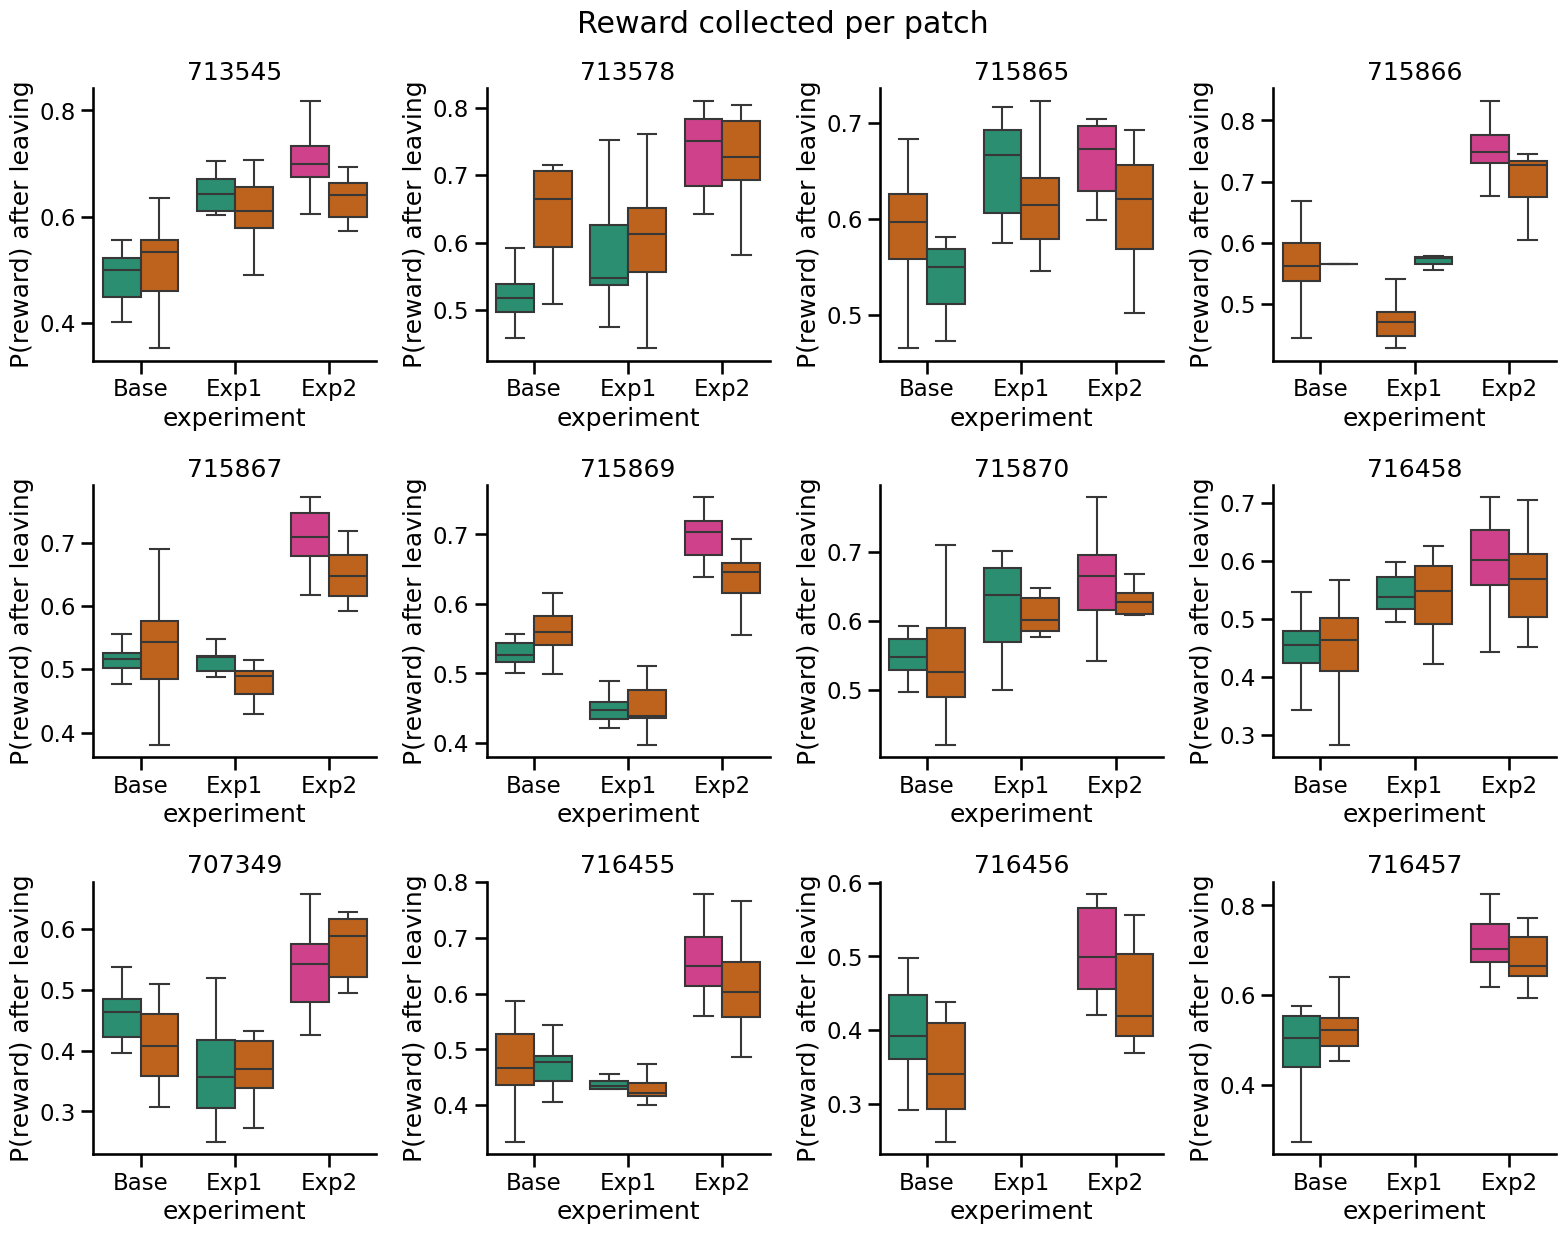

In [25]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_probability', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['base', 'experiment1', 'experiment2'])  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.ylabel('P(reward) after leaving')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

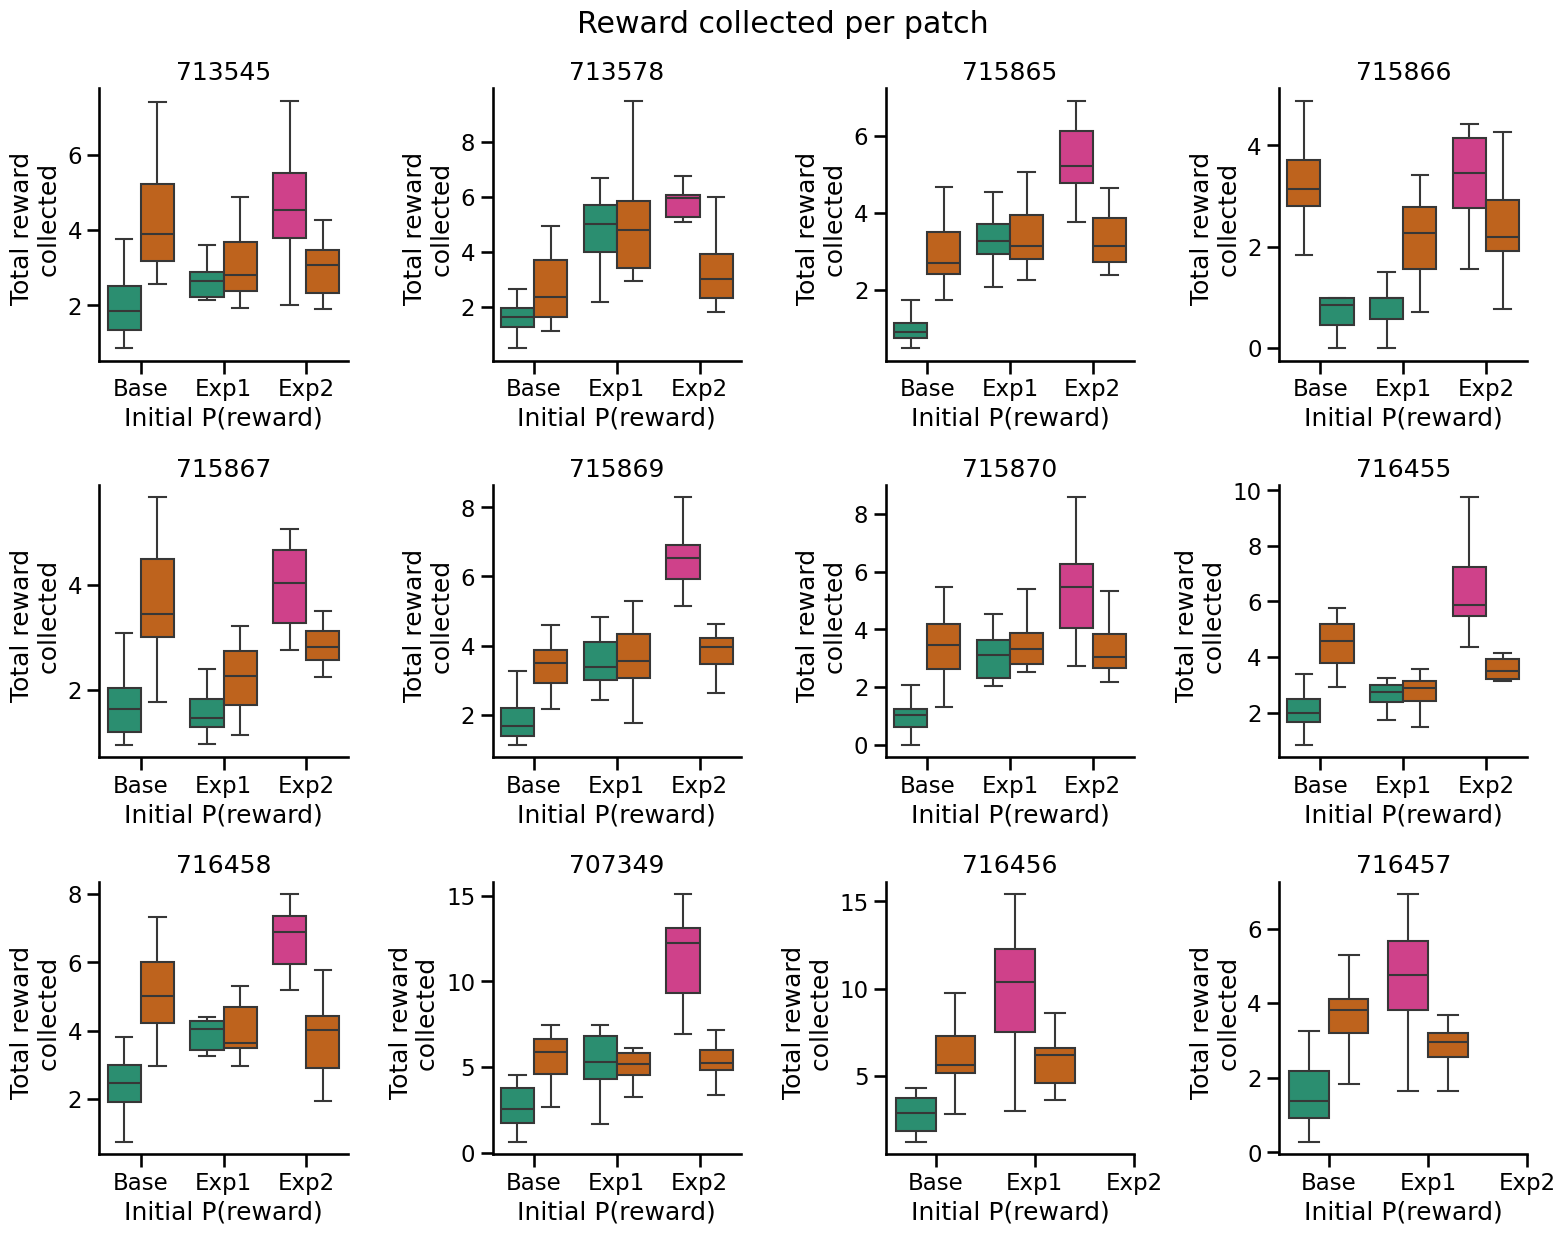

In [26]:
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        # Note: This is a conceptual step; you'll need to adjust based on your specific needs
        
        sns.boxplot(x='experiment', y='reward_delivered', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5)  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.xlabel('Initial P(reward)')
    plt.ylabel('Total reward \n collected')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

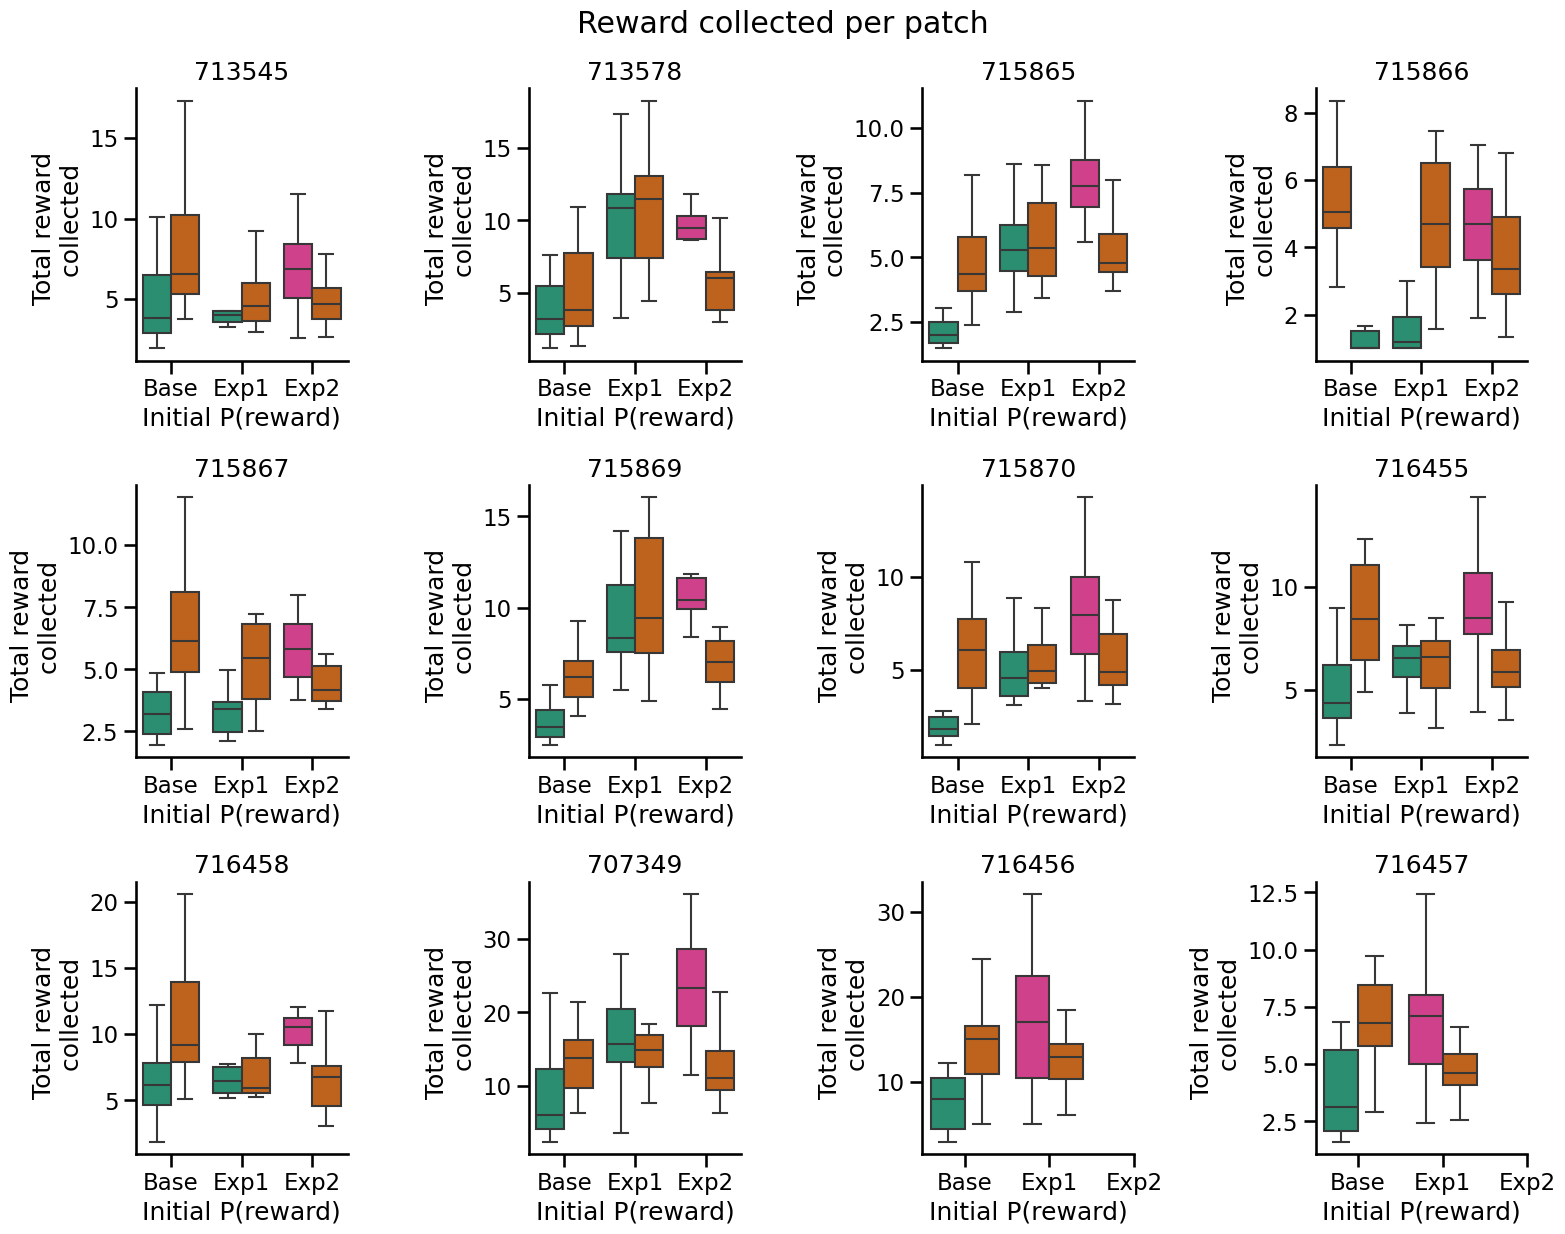

In [27]:
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        # Note: This is a conceptual step; you'll need to adjust based on your specific needs
        
        sns.boxplot(x='experiment', y='visit_number', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5)  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.xlabel('Initial P(reward)')
    plt.ylabel('Total reward \n collected')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(results_path+f'/total_stops_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

##### Example mouse

In [ ]:
mouse = 715870

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(9,4.5))

summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'}).reset_index()

summary = summary.loc[summary.mouse == mouse]
summary = summary.groupby(['session','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

axes = ax[0]
sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

for session in summary.session.unique():
    y = summary.loc[(summary.session == session)&(summary['experiment']=='base')].reward_delivered.values
    x = summary.loc[(summary.session == session)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Rewards collected')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(0,8)

summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[summary.mouse == mouse]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]

summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

axes = ax[1]
sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

for session in summary.session.unique():
    y = summary.loc[(summary.session == session)&(summary['experiment']=='base')].reward_probability.values
    x = summary.loc[(summary.session == session)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('p(reward) when leaving')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(0.2,1)

# Stops --------------------------------
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[summary.mouse == mouse]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

axes = ax[2]
sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

for session in summary.session.unique():
    y = summary.loc[(summary.session == session)&(summary['experiment']=='base')].visit_number.values
    x = summary.loc[(summary.session == session)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Stops')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
# axes.set_ylim(0,8)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
sns.despine()
plt.suptitle(mouse)
print(summary.loc[summary['experiment']=='base'].session.nunique())
plt.tight_layout()
# plt.savefig(results_path+f'/{mouse}_summary_basic_MVT.svg', dpi=300, bbox_inches='tight')


#### All animals

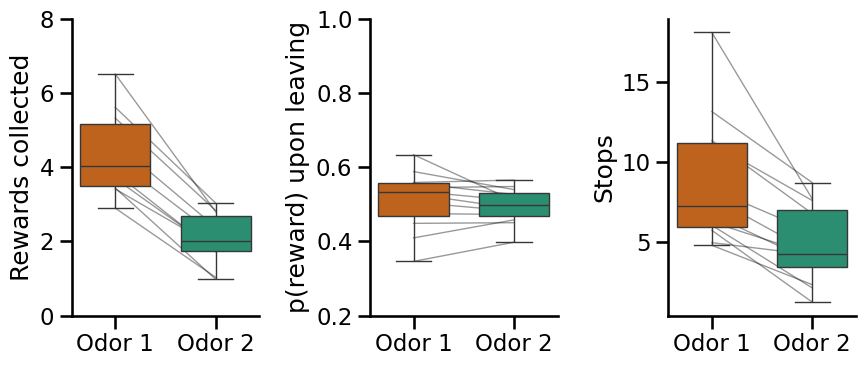

In [30]:
fig,ax = plt.subplots(1,3, figsize=(9,4))

summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[summary.mouse != 713578]
summary = summary.loc[summary.mouse != 715866]
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_delivered'].mean().reset_index()

axes = ax[0]
sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].reward_delivered.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Rewards collected')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(0,8)

summary = summary.loc[summary.mouse != '713578']
summary = summary.loc[summary.mouse != '715866']
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_probability'].mean().reset_index()

axes = ax[1]
sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].reward_probability.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('p(reward) upon leaving')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
# axes.set_yticks([0.0, 0.25, 0.5, 0.75,1])
axes.set_xlabel('')
axes.set_ylim(0.2,1)

# Stops --------------------------------
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[summary.mouse != '713578']
summary = summary.loc[summary.mouse != '715866']
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['visit_number'].mean().reset_index()

axes = ax[2]
sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].visit_number.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Stops')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
# axes.set_ylim(0,8)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
sns.despine()

plt.tight_layout()
plt.savefig(results_path+f'/rewards_collected_all_tall.svg', dpi=300, bbox_inches='tight')


##### Correlate time in the interpatch with the p(reward)

In [31]:
summary = summary.loc[summary.mouse != '713578']
summary = summary.loc[summary.mouse != '715866']
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_probability'].mean().reset_index()
summary = summary.loc[summary.experiment == 'base']
summary = summary.groupby('mouse').agg({'reward_probability':'mean'}).reset_index()

In [32]:
summary_df['next_site'] = summary_df['Seconds'].shift(-1)
summary_df['time_spent'] =  summary_df['next_site'] - summary_df.Seconds
test_df = summary_df.copy()
test_df.set_index('Seconds', inplace=True)
test_df = test_df.loc[test_df['label'] == 'InterPatch']
test_df = test_df.loc[~((test_df['mouse'] == 716456)&((test_df['session_number'] >= 24)|(test_df['session_number'] <= 5)))]
test_df = test_df.loc[test_df.engaged == True]
summary['time_spent'] = test_df.loc[test_df.experiment == 'experiment2'].groupby(['mouse']).time_spent.median().reset_index()['time_spent']

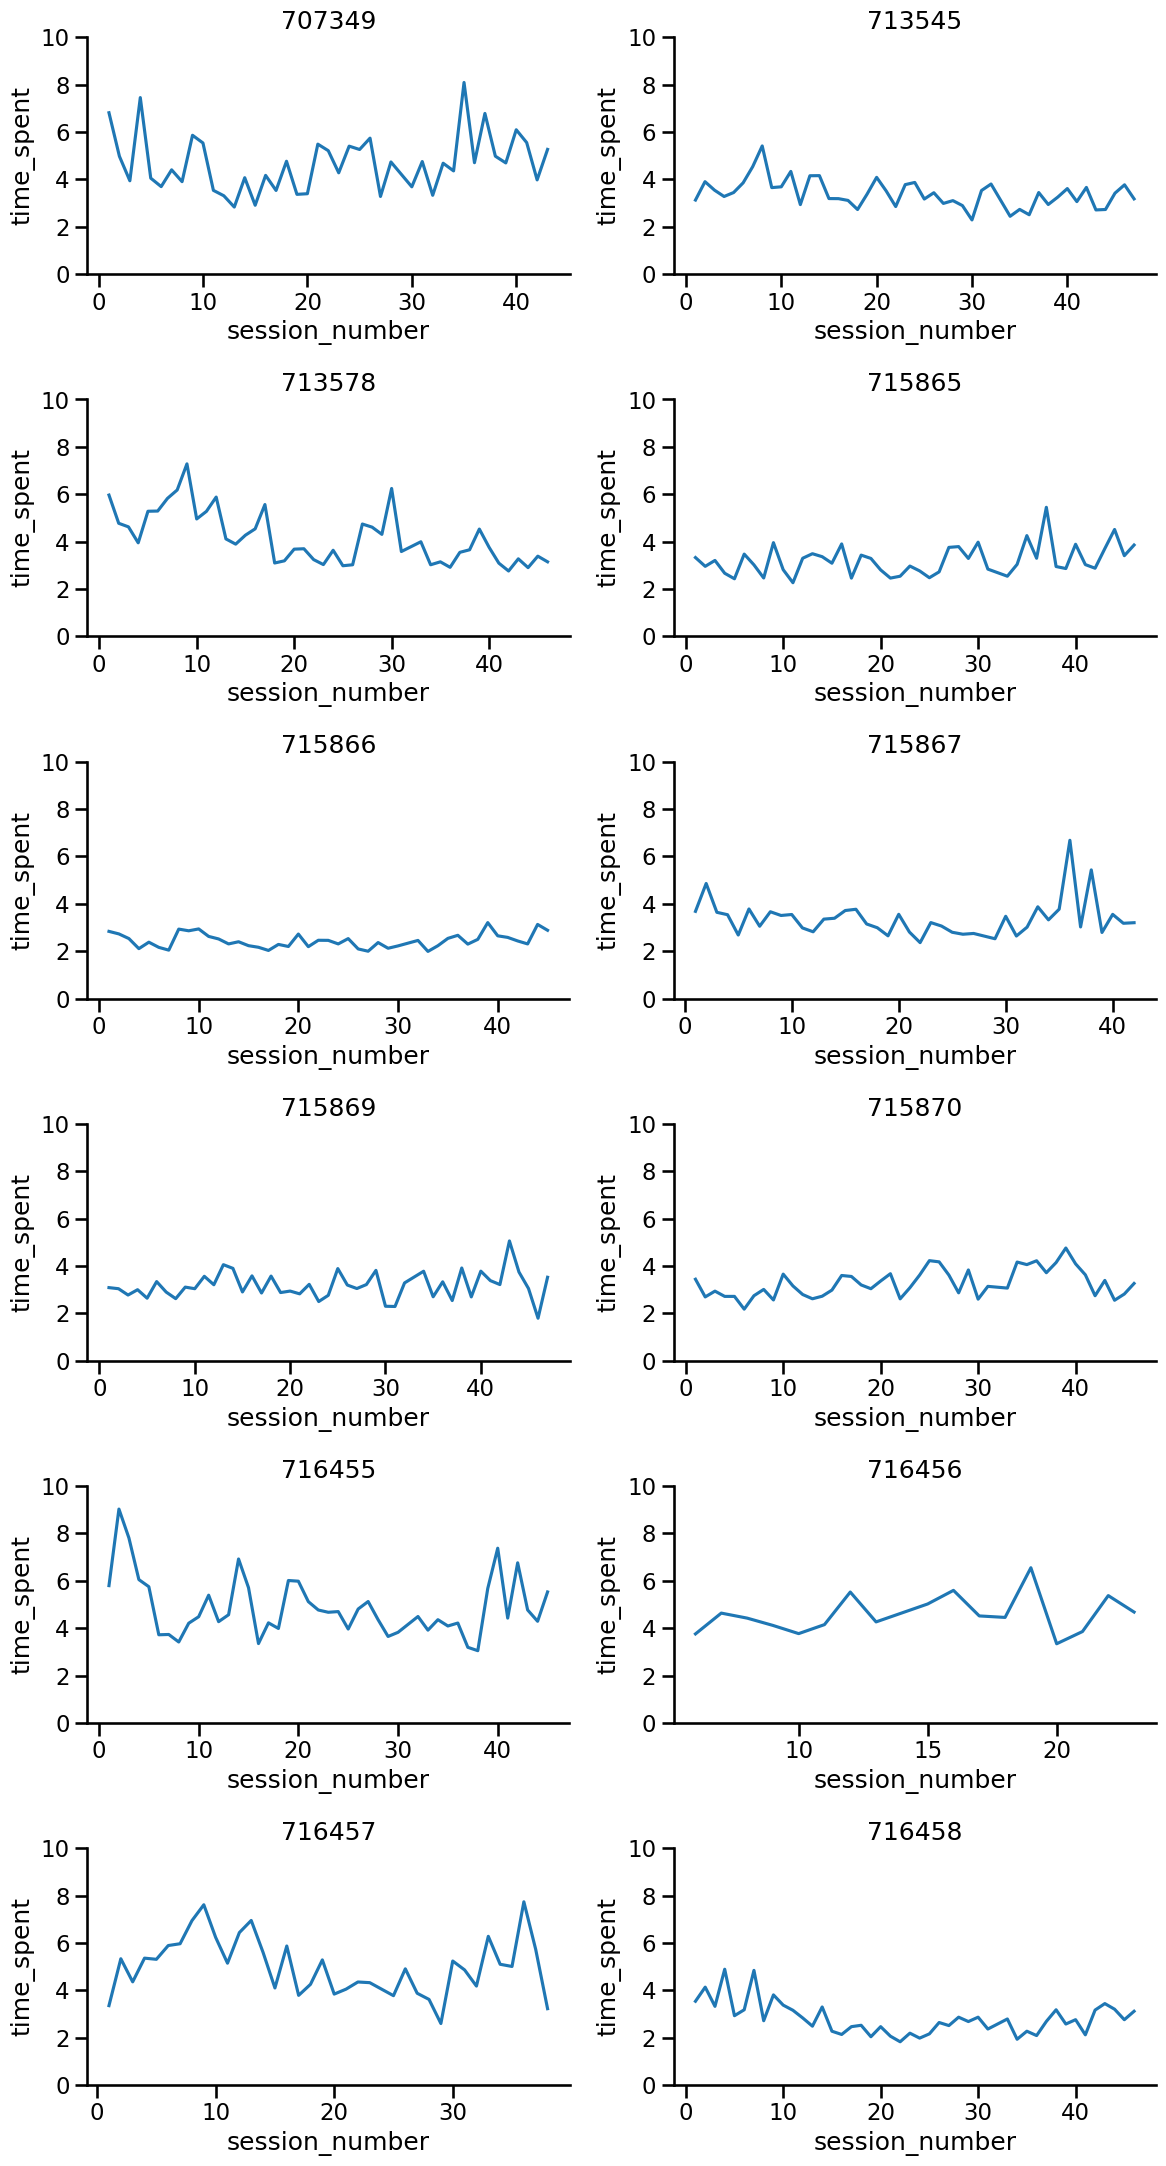

In [33]:
df = test_df.groupby(['mouse','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 2, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_number', y='time_spent', markers=True)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,10)
plt.tight_layout()
plt.show()

Correlation coefficient (pandas): -0.5815329566468711
Correlation coefficient (scipy): -0.5815329566468718
P-value: 0.047328262412888136


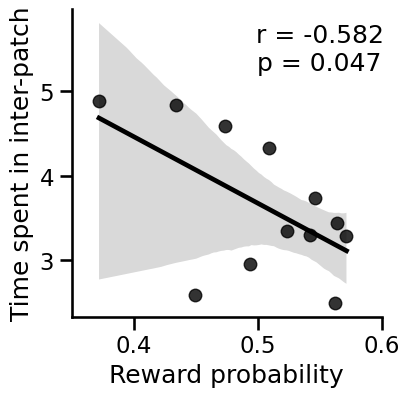

In [34]:
# Assuming summary DataFrame is already defined
# Calculate the correlation coefficient using pandas
correlation_matrix = summary[['reward_probability', 'time_spent']].corr()
correlation_coefficient = correlation_matrix.loc['reward_probability', 'time_spent']
print(f"Correlation coefficient (pandas): {correlation_coefficient}")

# Calculate the correlation coefficient and p-value using scipy
correlation_coefficient, p_value = pearsonr(summary['reward_probability'], summary['time_spent'])
print(f"Correlation coefficient (scipy): {correlation_coefficient}")
print(f"P-value: {p_value}")

fig = plt.figure(figsize=(size_col, size_row))
# Plot the regression plot
sns.regplot(data=summary, x='reward_probability', y='time_spent', color='black')
plt.text(0.55, 5.5, f"r = {correlation_coefficient:.3f}\np = {p_value:.3f}", ha='center', va='center')
plt.xlabel('Reward probability')
plt.ylabel('Time spent in inter-patch')
plt.xlim(0.35, 0.6)
sns.despine()
fig.savefig(results_path+f'/time_spent_vs_reward_probability.svg', dpi=300, bbox_inches='tight')

##### Other heuristics

experiment2: p = 0.0046449394299755776


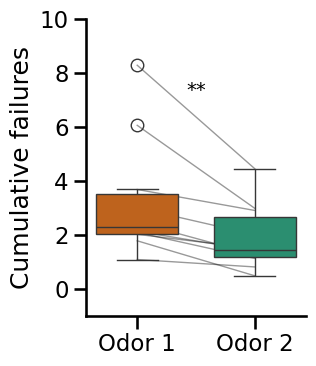

In [35]:
fig,ax = plt.subplots(1,1, figsize=(3.5,4))

summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'cumulative_failures':'max','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'cumulative_failures':'mean','visit_number':'mean'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[(summary.mouse != 713578)&(summary.mouse != 715866)]
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['cumulative_failures'].median().reset_index()

axes = ax
sns.boxplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].cumulative_failures.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

# Perform paired t-test
ethyl_butyrate = summary.loc[summary['experiment']=='base'].loc[summary['odor_label'] == 'Ethyl Butyrate', 'cumulative_failures']
alpha_pinene = summary.loc[summary['experiment']=='base'].loc[summary['odor_label'] == 'Alpha-pinene', 'cumulative_failures']
t_stat, p_value = ttest_rel(ethyl_butyrate, alpha_pinene)
print(f'{experiment}: p = {p_value}')
# Annotate significance
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    print('Here')
    significance = '*'
else:
    significance = 'ns'

# Add significance marker
max_y = max(max(ethyl_butyrate), max(alpha_pinene))
axes.text(0.5, 7, significance, ha='center', va='bottom', color='black', fontsize=14)

axes.set_ylabel('Cumulative failures')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(-1,10)

sns.despine()

plt.tight_layout()
plt.savefig(results_path+f'/cumulative_failures_heuristics.svg', dpi=300, bbox_inches='tight')


experiment2: p = 0.00558800176834435


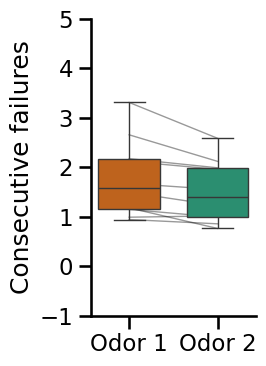

In [41]:
fig,ax = plt.subplots(1,1, figsize=(3,4))

summary = summary_df.loc[(summary_df.visit_number!=0 )&(summary_df.last_site==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'consecutive_failures':'max','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'consecutive_failures':'mean','visit_number':'mean'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[(summary.mouse != 713578)&(summary.mouse != 715866)]
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['consecutive_failures'].mean().reset_index()

axes = ax
sns.boxplot(x='odor_label', y='consecutive_failures', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].consecutive_failures.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

# Perform paired t-test
ethyl_butyrate = summary.loc[summary['experiment']=='base'].loc[summary['odor_label'] == 'Ethyl Butyrate', 'consecutive_failures']
alpha_pinene = summary.loc[summary['experiment']=='base'].loc[summary['odor_label'] == 'Alpha-pinene', 'consecutive_failures']
t_stat, p_value = ttest_rel(ethyl_butyrate, alpha_pinene)
print(f'{experiment}: p = {p_value}')
# Annotate significance
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    print('Here')
    significance = '*'
else:
    significance = 'ns'

# # Add significance marker
# max_y = max(max(ethyl_butyrate), max(alpha_pinene))
# axes.text(0.5, 7, significance, ha='center', va='bottom', color='black', fontsize=14)

axes.set_ylabel('Consecutive failures')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(-1,5)

sns.despine()

plt.tight_layout()
plt.savefig(results_path+f'/consecutive_failures_heuristics.svg', dpi=300, bbox_inches='tight')


In [ ]:
fig,ax = plt.subplots(1,1, figsize=(3.5,4))

summary = summary_df.loc[(summary_df.visit_number!=0 )&(summary_df.label=='RewardSite')].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'time_spent':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'time_spent':'mean','visit_number':'mean'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
# summary = summary.loc[(summary.mouse != 713578)&(summary.mouse != 715866)]
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['time_spent'].median().reset_index()

axes = ax
sns.boxplot(x='odor_label', y='time_spent', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']=='base'], order=['Ethyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].time_spent.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']=='base')].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Time spent in \n the patch (s)')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(0,60)

sns.despine()

plt.tight_layout()
plt.savefig(results_path+f'/time_spent_heuristics.svg', dpi=300, bbox_inches='tight')


In [ ]:
summary = summary_df.loc[summary_df.visit_number !=0].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'cumulative_failures':'max'})
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','cumulative_failures':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(16,10))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 5, i + 1)
    sns.stripplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[(summary.mouse == mouse)&(summary.experiment=='base')], ax =ax, jitter=-0.25)
    sns.stripplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette =  ['red','red','red'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[(summary.mouse == mouse)&(summary.experiment=='experiment1')], ax =ax, jitter=0.25)
    
    # sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    sns.boxplot(x='odor_label', y='cumulative_failures', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total no rewards\n when leaving')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-1, 13)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total visits per odor per mouse', fontsize=20)
plt.tight_layout()

# fig.savefig(foraging_figures+f'/PrewardDecrease_total_failures_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.last_visit ==1)&(summary_df.visit_number != 0)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 
                                'consecutive_failures':'min'}).reset_index()

summary['visit_number_count'] = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment', 'active_patch'])['visit_number'].sum().values
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'consecutive_failures':'mean', 'visit_number_count': 'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number_count", hue='odor_label', sizes=(30, 500), y='consecutive_failures', palette=color_dict_label, ax=ax, legend=False)

        # sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='o', ax=ax)

        # summary_average = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch', 'environment', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
        # summary_average = summary_average.loc[summary_average.active_patch >= 5]
        # summary_average = summary_average.groupby(['within_session_number','mouse', 'environment', 'experiment']).agg({'collected':'mean','reward_probability':'mean'}).reset_index()
        
        # sns.lineplot(x='within_session_number', y='reward_probability', color='black',  legend=False, data=summary_average.loc[(summary_average.mouse == mouse)&(summary_average.experiment == experiment)], marker='o')

        plt.title(f'{experiment}')

        plt.xlabel('')
        plt.ylabel('Total stops')
        # plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

#### **Modelling**

In [ ]:
df = pd.DataFrame()
df = pd.read_csv(r'C:\git\foraging-strategies\local\data\data.csv')

In [ ]:
df['travel_time'] = 3
reward_value = [5, 5]
a = [0.9, 0.6]
b = [2.76, 2.76]
c = [0.1278, 0.1278]
d = [0, 0]
indep_var = 'reward_rate'

df = df.loc[df.strategy != 'rate']

fig, ax = plt.subplots(figsize=(4, 4))
# sns.swarmplot(x ='strategy', y='reward_rate', data=df, legend=False, ax=ax, size=1)
sns.swarmplot(x ='strategy', y='reward_rate', data=df, legend=False, ax=ax, size=1)

mean_values = df.groupby('strategy')['reward_rate'].mean()

# Plot the mean as a horizontal line for each strategy
for i, strategy in enumerate(mean_values.index):
    x_position = df['strategy'].unique().tolist().index(strategy)
    ax.plot([x_position - 0.3, x_position + 0.3], [mean_values[strategy], mean_values[strategy]], color='black',  linewidth=2)

plt.xlabel('Strategy')
plt.ylabel('Reward rate')
plt.ylim(1,2.6)
sns.despine()
plt.xticks([0,1, 2, 3], ['Rewards', 'Stops','Failures', 'Consec. \n failures'], rotation=45)
plt.hlines(2.35, -0.5, 3.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.tight_layout()
fig.savefig(results_path+f'/strategy_reward_rate.svg', dpi=300, bbox_inches='tight')

In [ ]:
df_sum = pd.read_csv(r'C:\git\foraging-strategies\local\data\data_exploration.csv')

In [ ]:
# Plot the grid
fig = plt.figure(figsize=(5, 4))
heatmap_data = df_sum.loc[df_sum.strategy == 'rewards'].pivot(index = 'y', columns = 'x', values =  'reward_rate')
plt.imshow(heatmap_data, aspect='auto', cmap='mako', vmax=2)
plt.colorbar(label='Reward Rate')
plt.title('Rewards')
plt.xlabel('# Rewards Patch 1')
plt.ylabel('# Rewards Patch 2')
plt.grid(False)  # Turn off the default grid lines
sns.despine()
plt.show()
fig.savefig(results_path+f'/rewards_heatmap.svg', dpi=300, bbox_inches='tight')

### **Manipulation of global reward rate affects local choices**

##### Schematics

In [3]:
sns.set_context('talk')

fig, ax = plt.subplots(1, 2, figsize=(8,4))
marker = 'o'
ax1 = ax[0]

x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
a = 0.6
b = math.e  # Amplitude
c = 0.1284
d = 0

# Generate x values
y = a * pow(b, -c * x) + d

ax1.plot(x, y, color=color2, marker='.', linestyle='--')
# ax1.text(0.08, 0.05, f'old odor 2 = {a}', color=color2)

a = 0.9
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color1, marker=marker)
# ax1.text(2, 0.85, f'new odor 2 = {a}', color=color2)

a = 0.9
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color2, marker=marker, alpha=0.5)
# ax1.text(2, 0.75, f'Odor 1 = {a}', color=color1)
# ax1.text(3, 0.05, f'a = {a}', color=color3)

ax1.set_xlabel('Rewards collected')
ax1.set_ylabel('p(reward)')
# plt.hlines(0.6, 10, 0.6, color='k', linestyle='--')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)

specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax1.xaxis.set_major_locator(FixedLocator(specific_ticks))

ax1 = ax[1]

x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
a = 0.6
b = math.e  # Amplitude
c = 0.1284
d = 0

# Generate x values
y = a * pow(b, -c * x) + d

ax1.plot(x, y, color=color1, marker=marker)
# ax1.text(0.08, 0.05, f'new odor 1 = {a}', color=color1)

a = 0.9
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color1, marker='.', linestyle='--')
# ax1.text(2, 0.85, f'old odor 1 = {a}', color=color1)

a = 0.6
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color2, marker=marker, alpha=0.5)
# ax1.text(0.08, 0.15, f'Odor 2 = {a}', color=color2)
# ax1.text(3, 0.05, f'a = {a}', color=color3)

ax1.set_xlabel('Rewards collected')
ax1.set_ylabel('p(reward)')
# plt.hlines(0.6, 10, 0.6, color='k', linestyle='--')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)

specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax1.xaxis.set_major_locator(FixedLocator(specific_ticks))

sns.despine()
plt.tight_layout()
fig.savefig(results_path+'\schematic task_V3.svg', dpi=300)

NameError: name 'sns' is not defined

base mix: p = 0.0019128329409859714
experiment1 high: p = 0.2822537296192391
[707349 715866 715867 715869 716455]
base mix: p = 0.00042536777052373467
experiment1 low: p = 0.14072040721648296


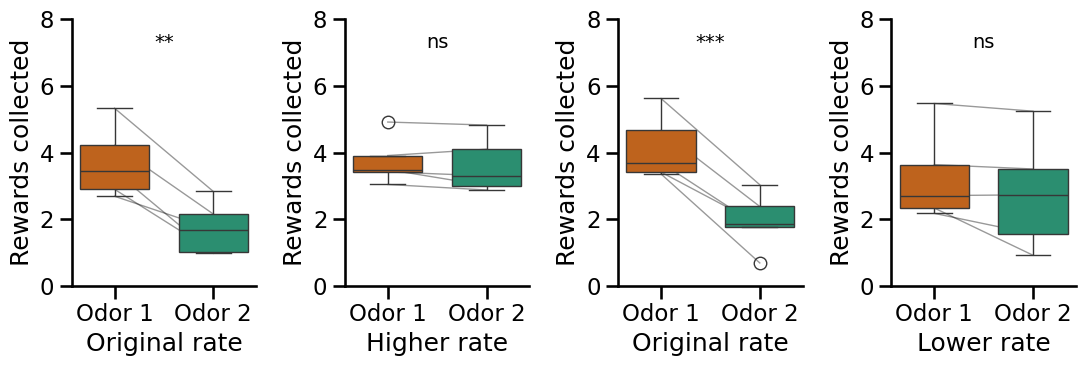

In [102]:
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[summary.mouse != '713578']
summary = summary.loc[summary.mouse != '715866']
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_delivered'].mean().reset_index()

list_high = summary.loc[summary.environment == 'high']['mouse'].unique()
list_low = summary.loc[summary.environment == 'low']['mouse'].unique()

fig, axs = plt.subplots(1,4, figsize=(size_col*2.8,size_row*1))
loop = 0

for experiment, environment, ax in zip(['base','experiment1','base','experiment1'],['mix','high','mix', 'low'], axs.flatten()):
    plot=summary.loc[(summary['experiment']==experiment)&(summary['environment']==environment)]
    
    if experiment == 'base':
        if loop == 0:
            plot = plot.loc[plot.mouse.isin(list_high)] 
            loop+=1
        elif loop == 1:
            plot = plot.loc[plot.mouse.isin(list_low)]   
            print(plot.mouse.unique()) 
            
    sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, data=plot, order=['Ethyl Butyrate', 'Alpha-pinene'], legend=False, zorder=10, width =0.7, ax=ax)

    # Create a plot with both scatter points and connecting lines
    for mouse in plot.mouse.unique():
        y = plot.loc[plot.mouse == mouse].reward_delivered.values
        x = plot.loc[plot.mouse == mouse].odor_label.values
        ax.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    # Perform paired t-test
    ethyl_butyrate = plot.loc[plot['odor_label'] == 'Ethyl Butyrate', 'reward_delivered']
    alpha_pinene = plot.loc[plot['odor_label'] == 'Alpha-pinene', 'reward_delivered']
    t_stat, p_value = ttest_rel(ethyl_butyrate, alpha_pinene)
    print(f'{experiment} {environment}: p = {p_value}')
    # Annotate significance
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        print('Here')
        significance = '*'
    else:
        significance = 'ns'

    # Add significance marker
    max_y = max(max(ethyl_butyrate), max(alpha_pinene))
    ax.text(0.5, 7, significance, ha='center', va='bottom', color='black', fontsize=14)
    
    ax.set_ylabel('Rewards collected')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
    sns.despine()
    ax.set_xticks([0,1], ['Odor 1', 'Odor 2'])
    plt.tight_layout()
    ax.set_ylim(0,8)
    
    if environment == 'mix':
        ax.set_xlabel('Original rate')
    elif environment == 'high':
        ax.set_xlabel('Higher rate')
    else:
        ax.set_xlabel('Lower rate')

plt.tight_layout()
plt.savefig(results_path+f'/rewards_collected_combined.svg', dpi=300, bbox_inches='tight')


base mix: p = 0.17798080541545097
experiment1 high: p = 0.27480917042285596
base mix: p = 0.9549574795828734
experiment1 low: p = 0.24660806281357983


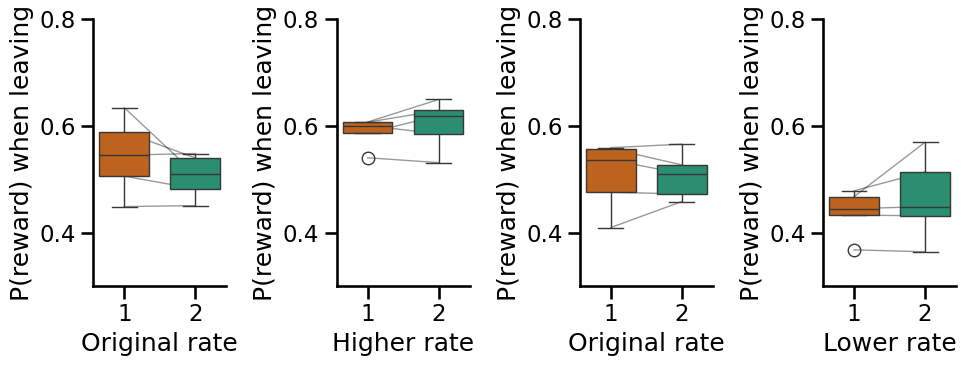

In [50]:
summary = summary.loc[summary.mouse != 713578]
summary = summary.loc[summary.mouse != 715866]
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_probability'].mean().reset_index()

fig, axs = plt.subplots(1,4, figsize=(size_col*2.5,size_row*1))
loop = 0

for experiment, environment, ax in zip(['base', 'experiment1', 'base', 'experiment1'], ['mix', 'high', 'mix', 'low'], axs.flatten()):
    plot = summary.loc[(summary['experiment'] == experiment) & (summary['environment'] == environment)]
    
    if experiment == 'base':
        if loop == 0:
            plot = plot.loc[plot.mouse.isin(list_high)]
            loop += 1
        elif loop == 1:
            plot = plot.loc[plot.mouse.isin(list_low)]
    
    sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette=color_dict_label, data=plot, order=['Ethyl Butyrate', 'Alpha-pinene'], legend=False, zorder=10, width=0.7, ax=ax)

    # Create a plot with both scatter points and connecting lines
    for mouse in plot.mouse.unique():
        y = plot.loc[plot.mouse == mouse].reward_probability.values
        x = plot.loc[plot.mouse == mouse].odor_label.values
        ax.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    # Perform paired t-test
    ethyl_butyrate = plot.loc[plot['odor_label'] == 'Ethyl Butyrate', 'reward_probability']
    alpha_pinene = plot.loc[plot['odor_label'] == 'Alpha-pinene', 'reward_probability']
    t_stat, p_value = ttest_rel(ethyl_butyrate, alpha_pinene)
    print(f'{experiment} {environment}: p = {p_value}')
    # Annotate significance
    if p_value < 0.05:
        significance = '*'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.001:
        significance = '***'
    else:
        significance = 'ns'

    # Add significance marker
    # max_y = max(max(ethyl_butyrate), max(alpha_pinene))
    # ax.text(0.5, 0.8, significance, ha='center', va='bottom', color='black', fontsize=12)

    ax.set_ylabel('P(reward) when leaving')
    sns.despine()
    ax.set_xticks([0,1], ['1', '2'])
    ax.set_ylim(0.3, 0.8)
    ax.set_yticks([0.4, 0.6, 0.8])
    
    if environment == 'mix':
        ax.set_xlabel('Original rate')
    elif environment == 'high':
        ax.set_xlabel('Higher rate')
    else:
        ax.set_xlabel('Lower rate')

plt.tight_layout()
plt.savefig(results_path + f'/preward_combined.svg', dpi=300, bbox_inches='tight')

base mix: p = 0.008210484671745231
experiment1 high: p = 0.1097999274406987
[707349 715866 715867 715869 716455]
base mix: p = 0.0019562978941645116
experiment1 low: p = 0.11704764414028446


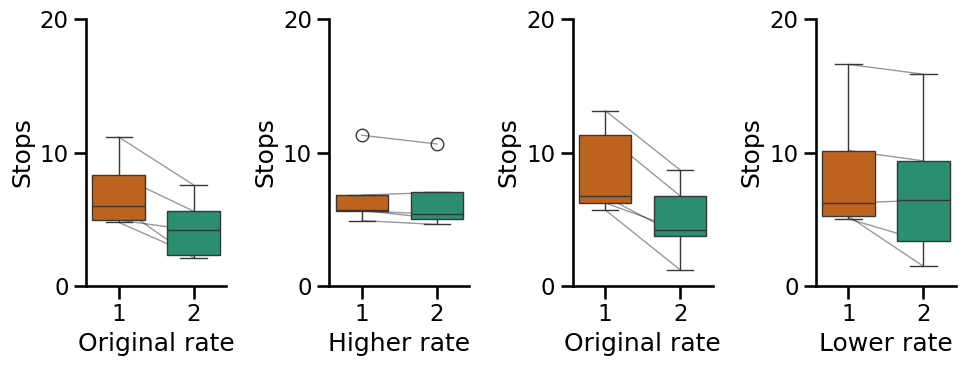

In [49]:
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.loc[summary.mouse != '713578']
summary = summary.loc[summary.mouse != '715866']
summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['visit_number'].mean().reset_index()

list_high = summary.loc[summary.environment == 'high']['mouse'].unique()
list_low = summary.loc[summary.environment == 'low']['mouse'].unique()

fig, axs = plt.subplots(1,4, figsize=(size_col*2.5,size_row))
loop = 0

for experiment, environment, ax in zip(['base','experiment1','base','experiment1'],['mix','high','mix', 'low'], axs.flatten()):
    plot=summary.loc[(summary['experiment']==experiment)&(summary['environment']==environment)]
    
    if experiment == 'base':
        if loop == 0:
            plot = plot.loc[plot.mouse.isin(list_high)] 
            loop+=1
        elif loop == 1:
            plot = plot.loc[plot.mouse.isin(list_low)]   
            print(plot.mouse.unique()) 
            
    sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, data=plot, order=['Ethyl Butyrate', 'Alpha-pinene'], legend=False, zorder=10, width =0.7, ax=ax)

    # Create a plot with both scatter points and connecting lines
    for mouse in plot.mouse.unique():
        y = plot.loc[plot.mouse == mouse].visit_number.values
        x = plot.loc[plot.mouse == mouse].odor_label.values
        ax.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    # Perform paired t-test
    ethyl_butyrate = plot.loc[plot['odor_label'] == 'Ethyl Butyrate', 'visit_number']
    alpha_pinene = plot.loc[plot['odor_label'] == 'Alpha-pinene', 'visit_number']
    t_stat, p_value = ttest_rel(ethyl_butyrate, alpha_pinene)
    print(f'{experiment} {environment}: p = {p_value}')
    # # Annotate significance
    # if p_value < 0.001:
    #     significance = '***'
    # elif p_value < 0.01:
    #     significance = '**'
    # elif p_value < 0.05:
    #     print('Here')
    #     significance = '*'
    # else:
    #     significance = 'ns'

    # Add significance marker
    # max_y = max(max(ethyl_butyrate), max(alpha_pinene))
    # ax.text(0.5, 7, significance, ha='center', va='bottom', color='black', fontsize=14)
    
    ax.set_ylabel('Stops')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
    sns.despine()
    ax.set_xticks([0,1], [])
    plt.tight_layout()
    ax.set_ylim(0,20)
    
    if environment == 'mix':
        ax.set_xlabel('Original rate')
    elif environment == 'high':
        ax.set_xlabel('Higher rate')
    else:
        ax.set_xlabel('Lower rate')
    ax.set_xticks([0,1], ['1', '2'])
    ax.set_yticks([0,10, 20])
    
plt.savefig(results_path+f'/stops_combined.svg', dpi=300, bbox_inches='tight')


In [103]:
test_df = summary_df[summary_df['engaged'] == True]
test_df = test_df[(test_df['label'] == 'RewardSite')]
test_df['next_has_choice'] = test_df['has_choice'].shift(-1)

In [126]:
cum_df = pd.DataFrame()
for mouse in test_df.mouse.unique():
    for session_n,session in enumerate(test_df[(test_df['mouse'] == mouse)].session.unique()):
        for X in np.arange(0,3):
            # Filter for rows where reward_delivered is 0
            filtered_df = test_df[(test_df['reward_delivered'] == 0)&(test_df.has_choice == 1)&(test_df['odor_label'] != 'Amyl Acetate')
                                    &(test_df['cumulative_failures'] == X) & (test_df['visit_number'] == 1) & (test_df['mouse'] == mouse)&(test_df['session'] == session)]

            # Group by odor_labels and calculate the probability of next_has_choice being False
            probability_df = filtered_df.groupby(['odor_label', 'environment', 'experiment'])['next_has_choice'].apply(lambda x: (x == False).mean()).reset_index()

            # Rename the columns for clarity
            probability_df.columns = ['odor_label', 'environment', 'experiment', 'p_leaving']
            if len(probability_df) != 2:
                print('Not enough data points to calculate the probability of leaving')
                continue
            # Display the result
            probability_df['mouse'] = mouse
            probability_df['cumulative_failures'] = X
            probability_df['session'] = session_n
            cum_df = pd.concat([cum_df, probability_df], axis=0)

Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of leaving
Not enough data points to calculate the probability of 

[707349 716455 715869 715867]


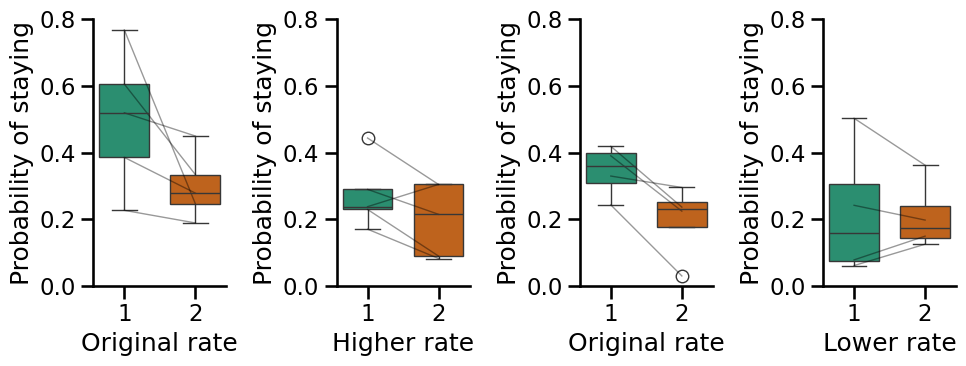

In [130]:

fig, axs = plt.subplots(1,4, figsize=(size_col*2.5,size_row))
loop = 0

for experiment, environment, ax in zip(['base','experiment1','base','experiment1'],['mix','high','mix', 'low'], axs.flatten()):
    plot=cum_df.loc[(cum_df['experiment']==experiment)&(cum_df['environment']==environment)]
    plot = plot.loc[plot.mouse != 715866 ]
    if experiment == 'base':
        if loop == 0:
            plot = plot.loc[plot.mouse.isin(list_high)] 
            loop+=1
        elif loop == 1:
            plot = plot.loc[plot.mouse.isin(list_low)]   
            print(plot.mouse.unique()) 
            
    df_results = plot.groupby(['odor_label', 'cumulative_failures', 'mouse'])['p_leaving'].mean().reset_index()
    plot['p_leaving'] = 1-plot['p_leaving']
    i=0
    sns.boxplot(data=df_results.loc[df_results.cumulative_failures == i], x='odor_label', y='p_leaving', palette=color_dict_label, ax=ax, width=0.7)
    for mouse in df_results.loc[df_results.cumulative_failures == i].mouse.unique():
        y = df_results.loc[(df_results.mouse == mouse)&(df_results.cumulative_failures == i)].p_leaving.values
        x = df_results.loc[(df_results.mouse == mouse)&(df_results.cumulative_failures == i)].odor_label.values
        ax.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)
    ax.set_ylabel('Probability of staying')
    if environment == 'mix':
        ax.set_xlabel('Original rate')
    elif environment == 'high':
        ax.set_xlabel('Higher rate')
    else:
        ax.set_xlabel('Lower rate')
        
    ax.set_xticks([0,1], ['1','2'])
    ax.set_ylim(0, 0.8)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.tight_layout()
sns.despine()
plt.show()

fig.savefig(results_path+f'/pleaving.svg', dpi=300, bbox_inches='tight')


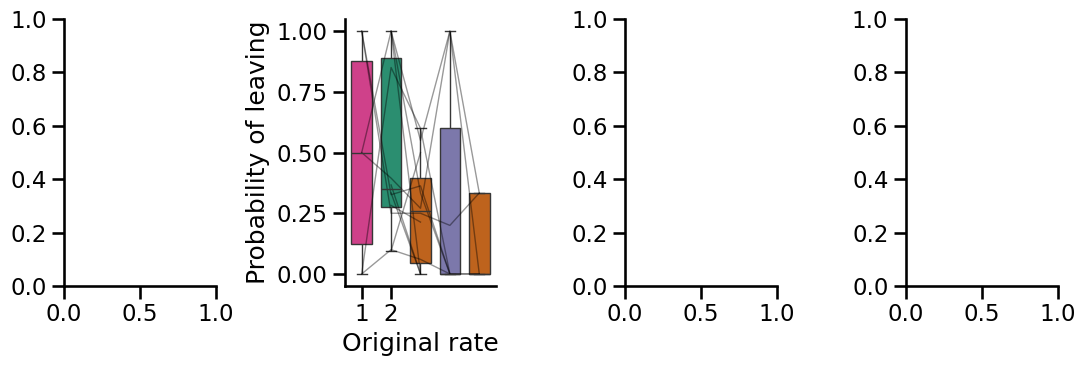

In [128]:
fig, ax = plt.subplots(1,4, figsize=(size_col*2.8,size_row))
df_results = cum_df.groupby(['odor_label', 'cumulative_failures', 'mouse'])['p_leaving'].mean().reset_index()
i=1
sns.boxplot(data=df_results.loc[df_results.cumulative_failures == i], x='odor_label', y='p_leaving', palette=color_dict_label, ax=ax[i], width=0.7)
for mouse in df_results.loc[df_results.cumulative_failures == i].mouse.unique():
    y = df_results.loc[(df_results.mouse == mouse)&(df_results.cumulative_failures == i)].p_leaving.values
    x = df_results.loc[(df_results.mouse == mouse)&(df_results.cumulative_failures == i)].odor_label.values
    ax[i].plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)
ax[i].set_ylabel('Probability of leaving')
ax[i].set_xticks([0,1], ['1','2'])
ax[i].set_xlabel('Original rate')
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(results_path+f'/probability_of_leaving_combined_experiment.svg', dpi=300, bbox_inches='tight')


#### **Session progression**

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        try:
            odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
            odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
            
            plot_df = pd.DataFrame()
            plot_df['session_n']= summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].groupby(['within_session_number','odor_label']).reward_probability.mean().reset_index()['within_session_number'].values
            plot_df['preward_odor1'] = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].groupby(['within_session_number','odor_label']).reward_probability.mean().values
            plot_df['preward_odor2'] = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].groupby(['within_session_number','odor_label']).reward_probability.mean().values
            plot_df['difference'] = plot_df['preward_odor1'] - plot_df['preward_odor2']

            sns.barplot(x='session_n', y='difference', data=plot_df,  ax=ax)
        except:
            pass
        plt.title(f'{experiment}')

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(-0.20,0.2)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='', ax=ax)

        plt.title(f'{experiment}')

        if experiment == 'base':
            plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
            plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# Assuming summary_df is your DataFrame

# Find the maximum value in the within_session_number column
max_value = summary.loc[summary.experiment == 'base']['within_session_number'].max()
summary = summary.loc[summary.experiment == 'base']

# Reverse the values in the within_session_number column
summary['reversed_within_session_number'] = max_value - summary.loc[summary.experiment == 'base']['within_session_number'] + 1
sns.scatterplot(
    data=summary, 
    x='reversed_within_session_number', 
    size="visit_number", 
    hue='odor_label', 
    sizes=(30, 500), 
    y='reward_probability', 
    palette=color_dict_label, 
    legend=False, 
    alpha=0.7
)


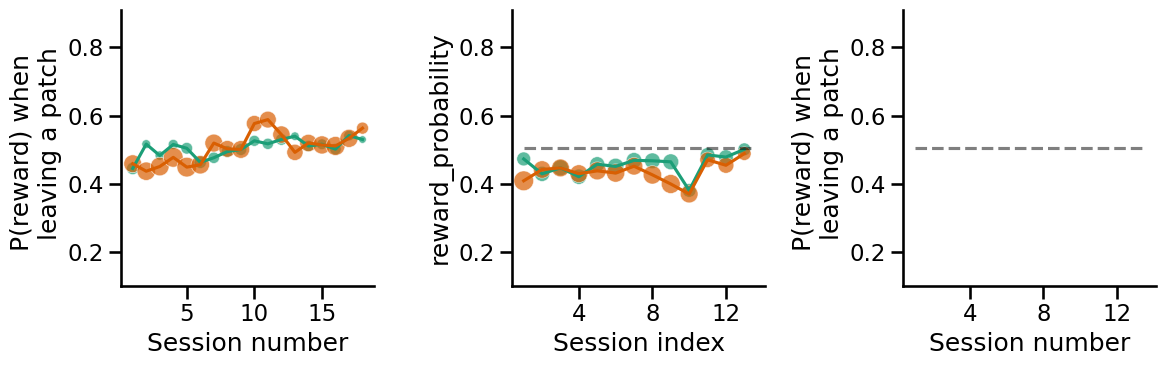

In [20]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
summary = summary.loc[summary.within_session_number <= 18]
summary = summary.loc[(summary.mouse != 713578)]
summary = summary.loc[summary.mouse.isin(list_low)].groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()
summary = summary.groupby(['within_session_number','odor_label', 'environment','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

fig = plt.figure(figsize=(12,4))

# print(summary.loc[summary.mouse == mouse])
# print('\n')
for i, experiment in enumerate(['base', 'experiment1']):
    ax = plt.subplot(1, 3, i + 1)
    
    if experiment == 'experiment1':
        sns.scatterplot(summary.loc[(summary.experiment == experiment)&(summary.environment =='low')], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 200), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)
        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)&(summary.environment =='low')], marker='', ax=ax,
                     errorbar=None)
        ax.set_ylim(0.10,0.91)
        ax.set_xticks([0, 4, 8, 12])
        plt.xlabel('Session index')
        ax.hlines(mean_bar, 1, 13.5, color='black', linestyle='--', alpha=0.5)

        ax = plt.subplot(1, 3, i + 2)
        sns.scatterplot(summary.loc[(summary.experiment == experiment)&(summary.environment =='high')], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 200), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)
        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)&(summary.environment =='high')], marker='', ax=ax,
                     errorbar=None)
        ax.set_ylim(0.10,0.91)
        ax.set_xticks([0, 4, 8, 12])
        ax.hlines(mean_bar, 1, 13.5, color='black', linestyle='--', alpha=0.5)
    else:
        sns.scatterplot(summary.loc[(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 200), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)], marker='', ax=ax)
        mean_bar = summary.loc[(summary.experiment == experiment)].reward_probability.mean()
    # if experiment == 'base':
    #     plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
    #     plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

    plt.xlabel('Session number')
    plt.ylabel('P(reward) when \n leaving a patch')

    plt.ylim(0.10,0.91)
    sns.despine()
    
plt.tight_layout()
plt.show()

fig.savefig(results_path+f'/session_progression_low.svg', dpi=300, bbox_inches='tight')

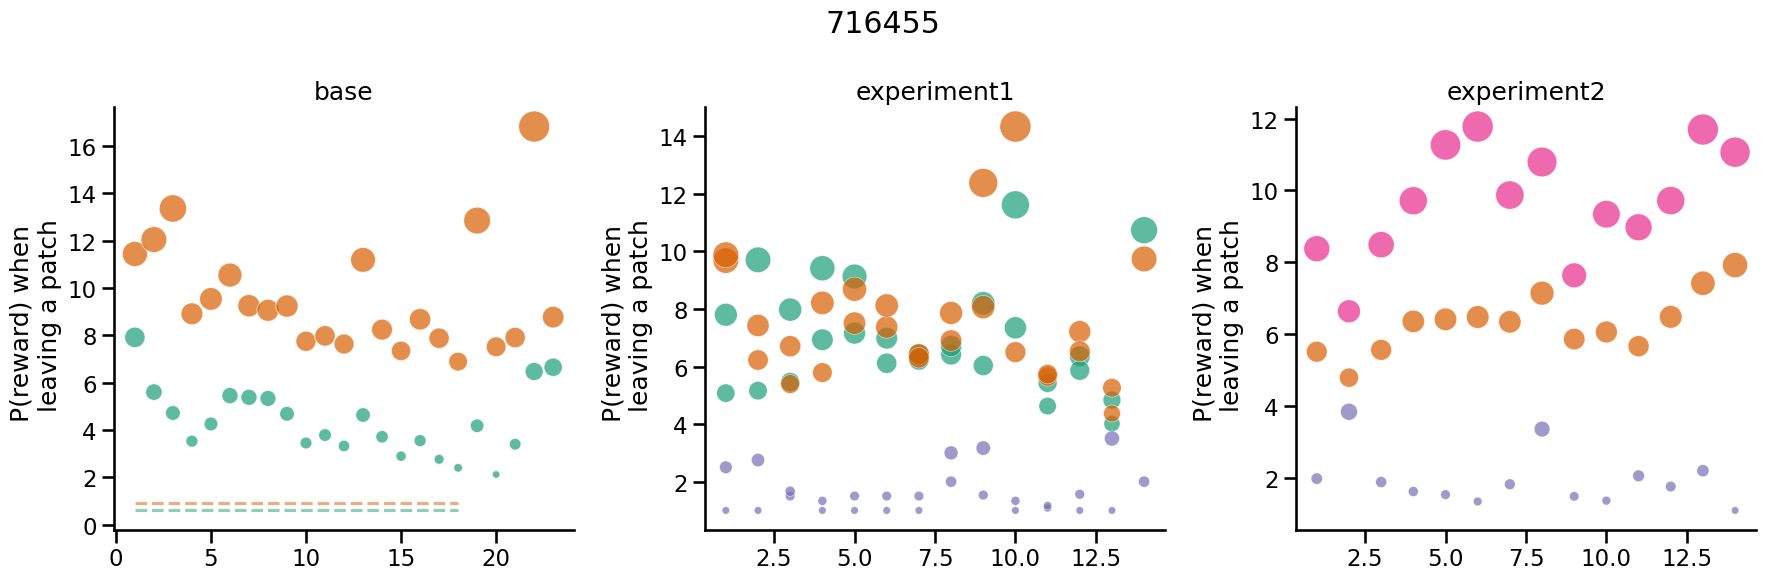

In [19]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'mean', 'reward_probability':'mean'}).reset_index()
summary = summary.groupby(['within_session_number','odor_label', 'environment','experiment']).agg({'visit_number':'mean', 'reward_probability':'mean'}).reset_index()

fig = plt.figure(figsize=(18,6))

# print(summary.loc[summary.mouse == mouse])
# print('\n')
for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
    ax = plt.subplot(1, 3, i + 1)
        
    sns.scatterplot(summary.loc[(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='visit_number', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

    # sns.lineplot(x='within_session_number', y='visit_number', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)], marker='', ax=ax)

    plt.title(f'{experiment}')

    if experiment == 'base':
        plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    # plt.ylim(0.10,0.91)
    sns.despine()
    
plt.suptitle(f'{mouse}')
plt.tight_layout()
plt.show()

fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
summary = summary.loc[summary.active_patch >= 10]

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='o', ax=ax)

        # summary_average = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch', 'environment', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
        # summary_average = summary_average.loc[summary_average.active_patch >= 5]
        # summary_average = summary_average.groupby(['within_session_number','mouse', 'environment', 'experiment']).agg({'collected':'mean','reward_probability':'mean'}).reset_index()
        
        # sns.lineplot(x='within_session_number', y='reward_probability', color='black',  legend=False, data=summary_average.loc[(summary_average.mouse == mouse)&(summary_average.experiment == experiment)], marker='o')

        plt.title(f'{experiment}')

        if experiment == 'base':
            plt.hlines(0.9, 1, 15, color=color1, linestyle='--', alpha=0.5)
            plt.hlines(0.6, 1, 15, color=color2, linestyle='--', alpha=0.5)

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.15,0.91)
        sns.despine()
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

## **Next steps**

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
a = 5
b = math.e  # Amplitude
# c = 0.1284
c = 0
d = 0

ax2 = ax[0][0]
# Generate x values
y = a * pow(b, -c * x) + d
ax2.plot(x, y, color='black', marker='o')
ax2.set_xlabel('Rewards collected')
ax2.set_ylabel('Volume (μl)')
ax2.set_ylim(-0.1,5.5)

specific_ticks = [0, 1, 2, 3, 4, 5]
ax2.yaxis.set_major_locator(FixedLocator(specific_ticks))
specific_ticks = [0, 5 , 10]
ax2.xaxis.set_major_locator(FixedLocator(specific_ticks))

x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
a = 0.9
b = math.e  # Amplitude
# c = 0.1284
c = 0
d = 0

ax1 = ax[1][0]
# Generate x values
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color='black', marker='o')
ax1.set_xlabel('Rewards collected')
ax1.set_ylabel('p(reward)')
ax1.set_ylim(-0.1,1.1)

specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax1.xaxis.set_major_locator(FixedLocator(specific_ticks))

marker = 'o'

ax4 = ax[1][1]
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
y = [7,7,7,0,0,0,0,0,0,0]

ax4.plot(x, y, color=color1, marker=marker)

x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
y = [3,3,3,3,3,3,3,0,0,0]

ax4.plot(x, y, color=color2, marker=marker)

y = np.repeat(0, 10)
ax4.plot(x, y, color=color3, marker=marker)
ax4.set_xlabel('Rewards collected')
ax4.set_ylabel('Volume per reward (μl)')

specific_ticks = [0, 1, 2, 3, 4, 5, 6, 7]
ax4.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax4.xaxis.set_major_locator(FixedLocator(specific_ticks))

# ----------------------------
ax1 = ax[0][1]

x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
a = 0.6
b = math.e  # Amplitude
c = 0.1284
d = 0

# Generate x values
y = a * pow(b, -c * x) + d

ax1.plot(x, y, color=color2, marker=marker)
# ax1.text(0.15, 0.15, f'a = {a}', color=color2)

a = 0.9
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color1, marker=marker)
# ax1.text(2, 0.75, f'a = {a}', color=color1)

a = 0.0
y = a * pow(b, -c * x) + d
ax1.plot(x, y, color=color3, marker=marker)
# ax1.text(3, 0.05, f'a = {a}', color=color3)

ax1.set_xlabel('Rewards collected')
ax1.set_ylabel('p(reward)')
# plt.hlines(0.6, 10, 0.6, color='k', linestyle='--')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)

specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax1.xaxis.set_major_locator(FixedLocator(specific_ticks))

sns.despine()
plt.tight_layout()
fig.savefig(results_path+'\schematic task_V2.svg', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
marker = 'o'
ax1 = ax[0]
# Generate x values
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
y = [0.9,0,0,0,0,0,0,0,0,0]
ax1.plot(x, y, color=color1, marker=marker)
ax1.set_xlabel('Stops')
ax1.set_ylabel('p(reward)')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)
specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

ax1 = ax[1]
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
y = [0,0,0.9,0.9,0.9,0,0,0,0,0]
ax1.plot(x, y, color=color2, marker=marker)
ax1.set_xlabel('Stops')
ax1.set_ylabel('p(reward)')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)
specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

ax1 = ax[2]
x = np.linspace(0, 10, 10)  # Generate 100 points between 0 and 5
y = np.repeat(0,10)
ax1.plot(x, y, color=color3, marker=marker)
ax1.set_xlabel('Stops')
ax1.set_ylabel('p(reward)')
ax1.set_ylim(-0.1,1)
ax1.set_xlim(-0.5,10.5)
specific_ticks = [0, 0.5 , 1]
ax1.yaxis.set_major_locator(FixedLocator(specific_ticks))

specific_ticks = [0, 5 , 10]
ax1.xaxis.set_major_locator(FixedLocator(specific_ticks))

sns.despine()
plt.tight_layout()
fig.savefig(results_path+'\schematic task_V4.svg', dpi=300)